<a href="https://colab.research.google.com/github/Kusanis/ChatBox/blob/main/Final_Year_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [ ]:
BTC = yf.Ticker('BTC-USD')
data = BTC.history(start='2010-03-01',end='2025-03-01')

In [ ]:
Scaler = MinMaxScaler()
data[['Close']] = Scaler.fit_transform(data[['Close']])
data['prev1'] = data['Close'].shift(1)
data['prev2'] = data['Close'].shift(2)
data['prev3'] = data['Close'].shift(3)
data['prev4'] = data['Close'].shift(4)
data['prevh1'] = data['High'].shift(1)
data['prevh2'] = data['High'].shift(2)
data['prevh3'] = data['High'].shift(3)
data['prevh4'] = data['High'].shift(4)
data['prevl1'] = data['Low'].shift(1)
data['prevl2'] = data['Low'].shift(2)
data['prevl3'] = data['Low'].shift(3)
data['prevl4'] = data['Low'].shift(4)
# Calculate Simple Moving Average (SMA)
data['SMA'] = data['prev1'].rolling(window=7).mean()

# Calculate Exponential Moving Average (EMA)
data['EMA'] = data['prev1'].ewm(span=30, adjust=False).mean()

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI
data['RSI'] = calculate_rsi(data['prev1'], 14)
data = data.drop(data[['Open','High','Low','Dividends','Stock Splits']],axis=1)
data = data.dropna()
data['Date'] = data.index


In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, shuffle = False)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, shuffle = False)

In [ ]:
# Sample data (Replace these with actual data)
X_train = train_df[['prev1','prev2','prev3','prev4','prevl1','prevl2','prevl3','prevl4','prevh1','prevh2','prevh3','prevh4']]
y_train = train_df['Close']

X_test = test_df[['prev1','prev2','prev3','prev4','prevl1','prevl2','prevl3','prevl4','prevh1','prevh2','prevh3','prevh4']]
y_test = test_df['Close']

X_val = val_df[['prev1','prev2','prev3','prev4','prevl1','prevl2','prevl3','prevl4','prevh1','prevh2','prevh3','prevh4']]
y_val = val_df['Close']

# **ML**

## **RANDOM FOREST REGRESSOR**

In [ ]:
# Assume X and y are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define search space for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Initialize RandomForestRegressor with suggested hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Train model
    rf.fit(X_train, y_train)

    # Predict on test data
    y_pred = rf.predict(X_val)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse  # Optuna will minimize RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Increase n_trials for better tuning

# Best parameters found
print("Best hyperparameters:", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Predictions & Performance Metrics
y_pred_best = rf_best.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Compute TWAP and VWAP performance metrics
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred_best * weights) / np.sum(weights)
vwap = np.sum(y_pred_best * y_test) / np.sum(y_test)

performance_metrics_rfr = {
    "RMSE": rmse,
    "MSE": mse,
    "MAE": mae,
    "R2": r2,
    "TWAP": twap,
    "VWAP": vwap
}

print(performance_metrics_rfr)


[I 2025-04-18 03:05:00,978] A new study created in memory with name: no-name-ed1e27e5-c712-4cc4-8d9f-290fd46c5d18
[I 2025-04-18 03:05:01,356] Trial 0 finished with value: 0.008680853325944171 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.008680853325944171.
[I 2025-04-18 03:05:02,778] Trial 1 finished with value: 0.00854134846914135 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.00854134846914135.
[I 2025-04-18 03:05:03,614] Trial 2 finished with value: 0.008662532567289688 and parameters: {'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.00854134846914135.
[I 2025-04-18 03:05:04,385] Trial 3 finished with value: 0.008490317095440335 and parameters: {'n_estimators': 100, 'max_dept

Best hyperparameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
{'RMSE': np.float64(0.17297962500587136), 'MSE': 0.029921950667171873, 'MAE': 0.10969607867101452, 'R2': -0.33239183947158235, 'TWAP': np.float64(0.5845714493391814), 'VWAP': np.float64(0.5887111213770662)}


In [ ]:
# Train final model with best hyperparameters
best_params = study.best_params
rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Predictions & Performance Metrics
y_pred_best = rf_best.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Compute TWAP and VWAP performance metrics
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred_best * weights) / np.sum(weights)
vwap = np.sum(y_pred_best * y_test) / np.sum(y_test)

performance_metrics_rfr = {
    "RMSE": rmse,
    "MSE": mse,
    "MAE": mae,
    "R2": r2,
    "TWAP": twap,
    "VWAP": vwap
}

print(performance_metrics_rfr)

{'RMSE': np.float64(0.17297962500587136), 'MSE': 0.029921950667171873, 'MAE': 0.10969607867101452, 'R2': -0.33239183947158235, 'TWAP': np.float64(0.5870712961483031), 'VWAP': np.float64(0.5887111213770662)}


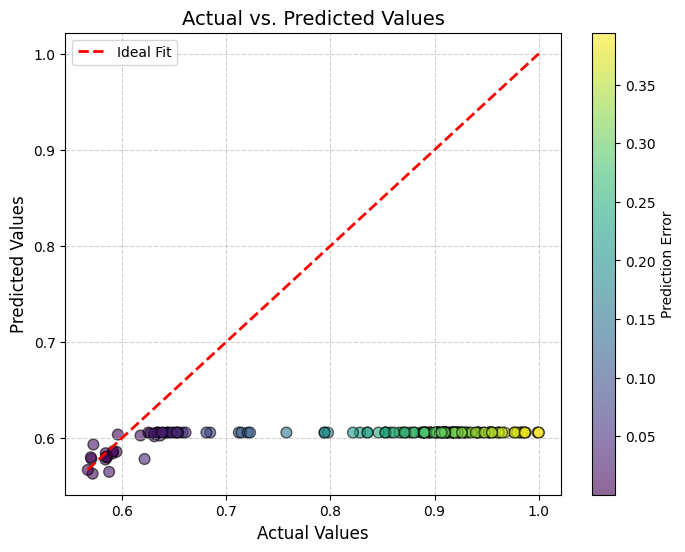

In [ ]:
# Define a color gradient based on error magnitude
errors = np.abs(y_test - y_pred_best)

plt.figure(figsize=(8, 6))  # Set figure size
sc = plt.scatter(y_test, y_pred_best, c=errors, cmap='viridis', alpha=0.6, edgecolors='k', s=60)

# Plot the ideal diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2, label="Ideal Fit")

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error")

# Labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs. Predicted Values', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


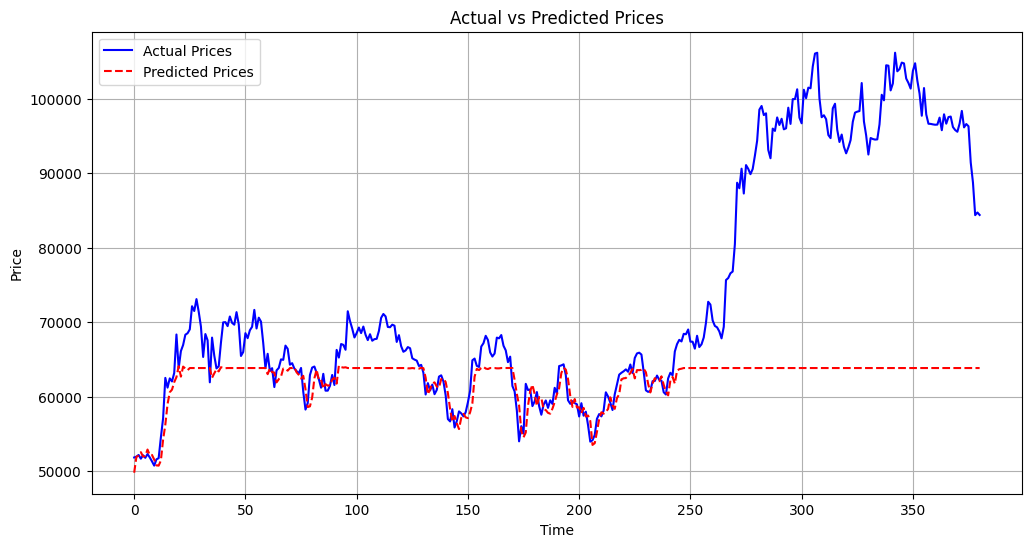

In [ ]:
# Ensure you use the same scaler that was used for fitting
y_test_inv = Scaler.inverse_transform(np.array(y_test).reshape(-1,1))
y_pred_best_inv = Scaler.inverse_transform(np.array(y_pred_best).reshape(-1,1))

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_pred_best_inv, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()



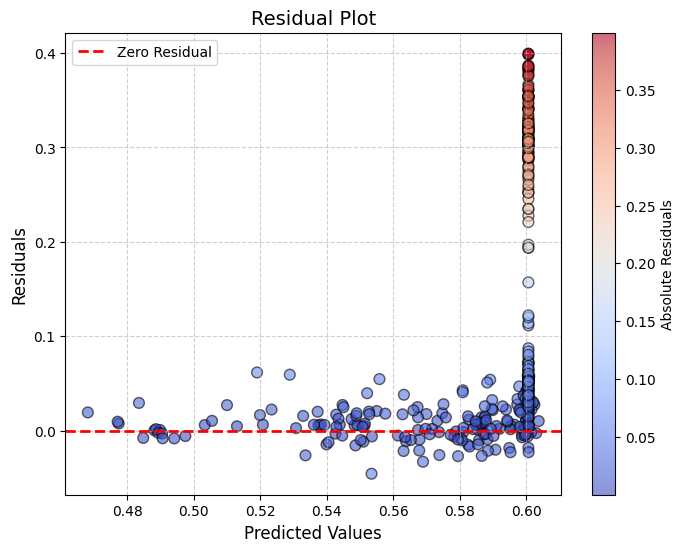

In [ ]:
# Compute residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(8, 6))  # Set figure size

# Scatter plot with color gradient
sc = plt.scatter(y_pred_best, residuals, c=np.abs(residuals), cmap='coolwarm', alpha=0.6, edgecolors='k', s=60)

# Horizontal reference line at zero residual
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual")

# Color bar to indicate residual magnitude
cbar = plt.colorbar(sc)
cbar.set_label("Absolute Residuals")

# Labels and title
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


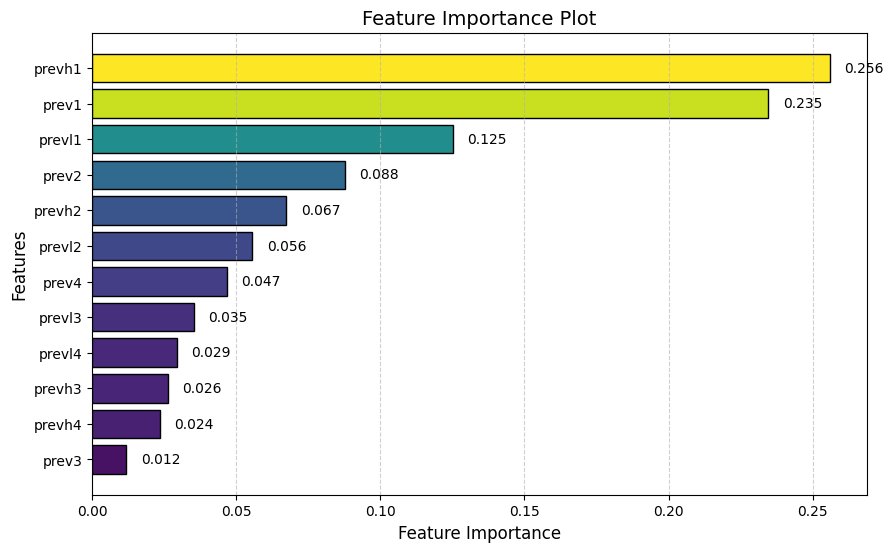

In [ ]:
# Example: Feature importances (assuming you have a trained model with feature_importances_)
importances = rf_best.feature_importances_
feature_names = X_train.columns  # Assuming you're using a Pandas DataFrame

# Sort feature importances
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Create figure
plt.figure(figsize=(10, 6))

# Bar plot
colors = plt.cm.viridis(sorted_importances / max(sorted_importances))  # Normalize for colormap
plt.barh(sorted_features, sorted_importances, color=colors, edgecolor='black')

# Add labels
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance Plot', fontsize=14)
plt.gca().invert_yaxis()  # Invert to show most important feature on top

# Add value labels
for i, v in enumerate(sorted_importances):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


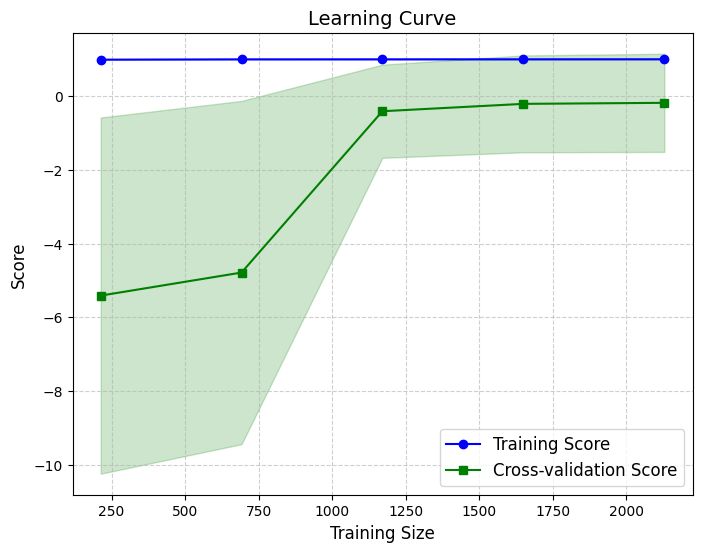

In [ ]:
# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_best, X_train, y_train, cv=5)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))

# Training score with shading for std deviation
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)

# Cross-validation score with shading
plt.plot(train_sizes, test_mean, 's-', color='green', label='Cross-validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

# Labels and title
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Learning Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


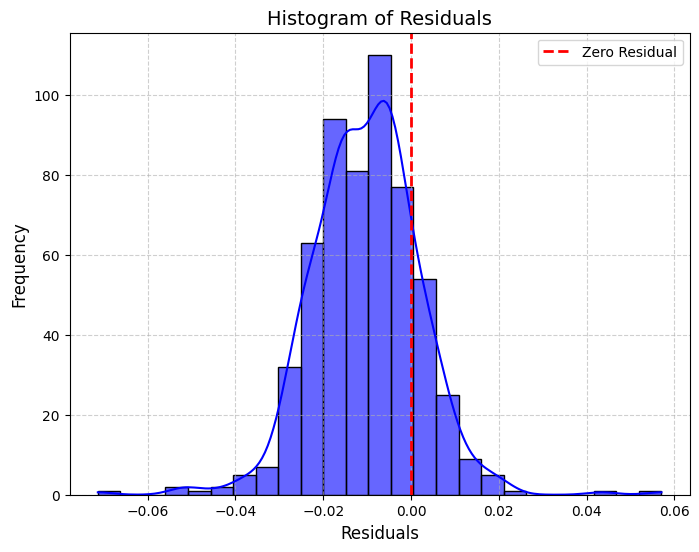

In [ ]:
# Set figure size
plt.figure(figsize=(8, 6))

# Plot histogram with KDE (density=True makes it comparable)
sns.histplot(residuals, bins=25, kde=True, color='blue', alpha=0.6, edgecolor='black')

# Add vertical line at zero residual
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

# Labels and title
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Residuals', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


## **Linear Regression**

In [ ]:
# Assume X and y are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(trial):
    # Select model type
    model_type = trial.suggest_categorical("model_type", ["ridge", "lasso"])
    alpha = trial.suggest_float("alpha", 0.0001, 10.0, log=True)  # Regularization strength

    if model_type == "ridge":
        model = Ridge(alpha=alpha, random_state=42)
    else:
        model = Lasso(alpha=alpha, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse  # Optuna will minimize RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Increase n_trials for better tuning

# Best parameters found
print("Best hyperparameters:", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
if best_params["model_type"] == "ridge":
    model_best = Ridge(alpha=best_params["alpha"], random_state=42)
else:
    model_best = Lasso(alpha=best_params["alpha"], random_state=42)

model_best.fit(X_train, y_train)

# Predictions & Performance Metrics
y_pred_best = model_best.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Compute TWAP and VWAP performance metrics
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred_best * weights) / np.sum(weights)
vwap = np.sum(y_pred_best * y_test) / np.sum(y_test)

performance_metrics_lr = {
    "RMSE": rmse,
    "MSE": mse,
    "MAE": mae,
    "R2": r2,
    "TWAP": twap,
    "VWAP": vwap
}

print(performance_metrics_lr)


[I 2025-04-18 03:06:34,164] A new study created in memory with name: no-name-c1c4c0a5-839b-403c-a0cb-8823425886d2
[I 2025-04-18 03:06:34,175] Trial 0 finished with value: 0.006975235863028442 and parameters: {'model_type': 'ridge', 'alpha': 0.006407497922201528}. Best is trial 0 with value: 0.006975235863028442.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.021e-01, tolerance: 7.058e-03
  model = cd_fast.enet_coordinate_descent(
[I 2025-04-18 03:06:34,216] Trial 1 finished with value: 0.007513330238448922 and parameters: {'model_type': 'lasso', 'alpha': 0.034445035517056834}. Best is trial 0 with value: 0.006975235863028442.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. 

Best hyperparameters: {'model_type': 'ridge', 'alpha': 0.0009590522195900285}
{'RMSE': np.float64(0.018786656669846125), 'MSE': 0.0003529384688306739, 'MAE': 0.013663384130897668, 'R2': 0.9842840347898337, 'TWAP': np.float64(0.6981142664933373), 'VWAP': np.float64(0.7221948290890059)}


In [ ]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Train final model with best hyperparameters
best_params = study.best_params
if best_params["model_type"] == "ridge":
    model_best = Ridge(alpha=best_params["alpha"], random_state=42)
else:
    model_best = Lasso(alpha=best_params["alpha"], random_state=42)

model_best.fit(X_train, y_train)

# Predictions & Performance Metrics
y_pred_best = model_best.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Compute TWAP and VWAP performance metrics
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred_best * weights) / np.sum(weights)
vwap = np.sum(y_pred_best * y_test) / np.sum(y_test)

performance_metrics_lr = {
    "RMSE": rmse,
    "MSE": mse,
    "MAE": mae,
    "R2": r2,
    "TWAP": twap,
    "VWAP": vwap
}

print(performance_metrics_lr)

{'RMSE': np.float64(0.018786656669846125), 'MSE': 0.0003529384688306739, 'MAE': 0.013663384130897668, 'R2': 0.9842840347898337, 'TWAP': np.float64(0.6957275845739445), 'VWAP': np.float64(0.7221948290890059)}


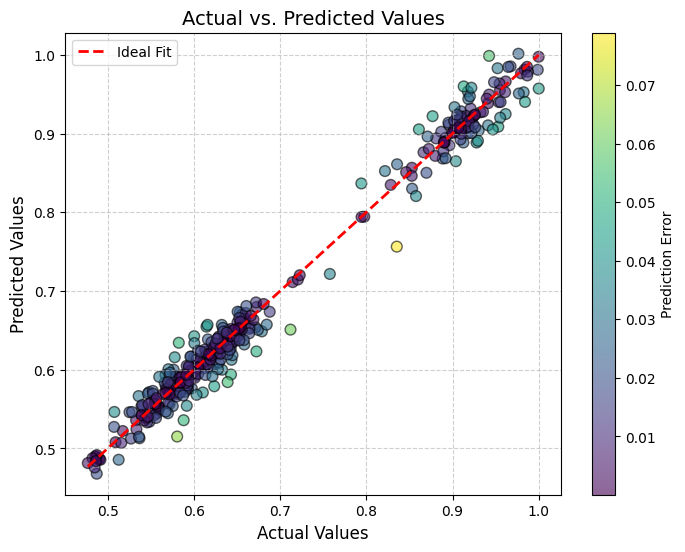

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color gradient based on error magnitude
errors = np.abs(y_test - y_pred_best)

plt.figure(figsize=(8, 6))  # Set figure size
sc = plt.scatter(y_test, y_pred_best, c=errors, cmap='viridis', alpha=0.6, edgecolors='k', s=60)

# Plot the ideal diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2, label="Ideal Fit")

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error")

# Labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs. Predicted Values', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


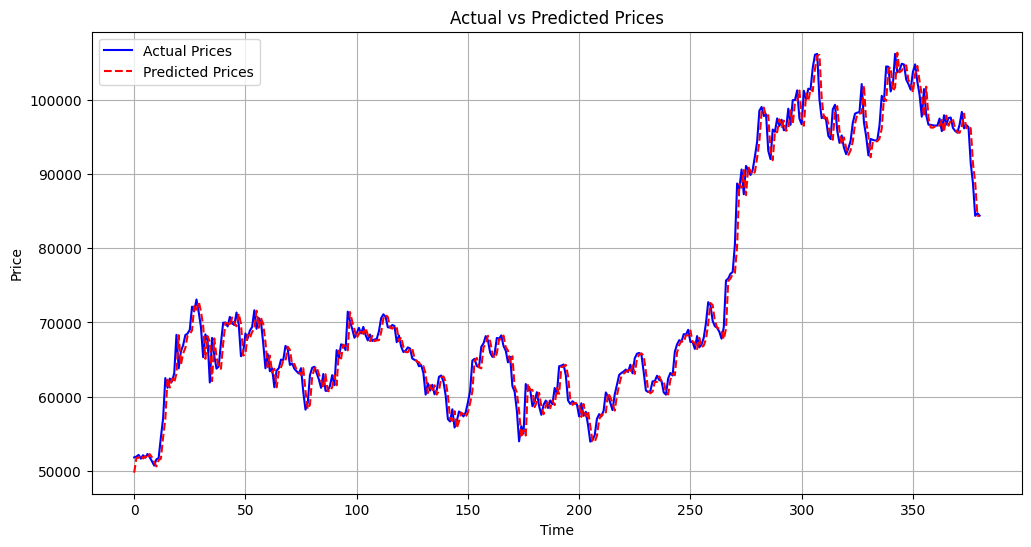

In [ ]:
import matplotlib.pyplot as plt

# Transform predicted and actual values back to the original scale
y_test_inv = Scaler.inverse_transform(
    np.column_stack([y_test, np.zeros((len(y_test), 4))]))[:, 0]
y_pred_best_inv = Scaler.inverse_transform(
    np.column_stack([y_pred_best, np.zeros((len(y_pred_best), 4))]))[:, 0]

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_pred_best_inv, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()


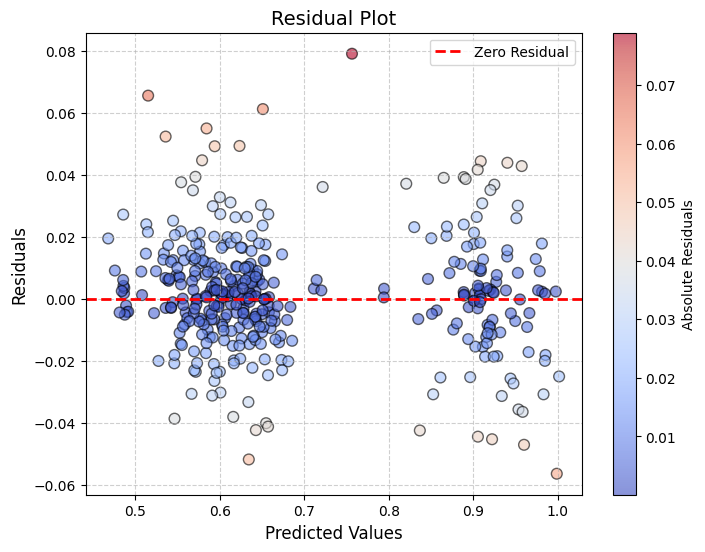

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(8, 6))  # Set figure size

# Scatter plot with color gradient
sc = plt.scatter(y_pred_best, residuals, c=np.abs(residuals), cmap='coolwarm', alpha=0.6, edgecolors='k', s=60)

# Horizontal reference line at zero residual
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual")

# Color bar to indicate residual magnitude
cbar = plt.colorbar(sc)
cbar.set_label("Absolute Residuals")

# Labels and title
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

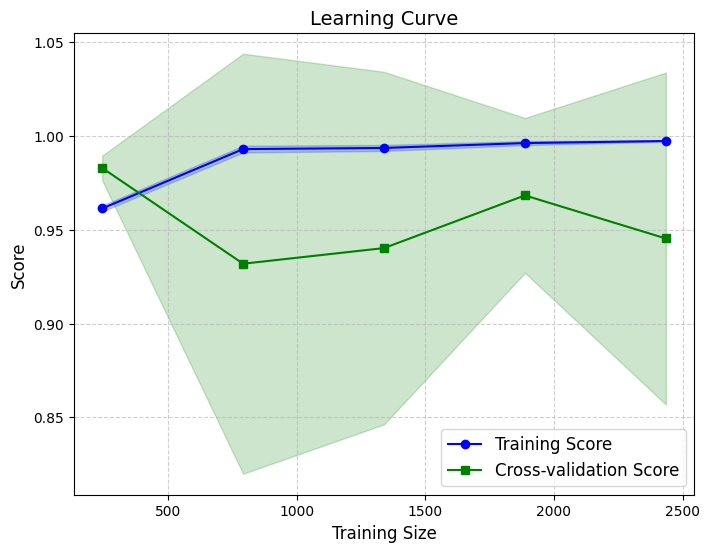

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(model_best, X_train, y_train, cv=5)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))

# Training score with shading for std deviation
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)

# Cross-validation score with shading
plt.plot(train_sizes, test_mean, 's-', color='green', label='Cross-validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

# Labels and title
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Learning Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


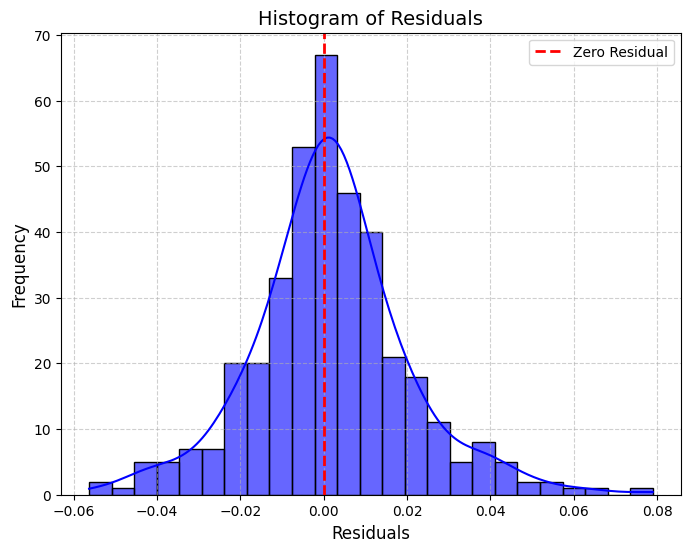

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size
plt.figure(figsize=(8, 6))

# Plot histogram with KDE (density=True makes it comparable)
sns.histplot(residuals, bins=25, kde=True, color='blue', alpha=0.6, edgecolor='black')

# Add vertical line at zero residual
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

# Labels and title
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Residuals', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## **Gradient Boosting Regressor**

In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Sample data (replace with your actual data)
# X = ... (feature matrix)
# y = ... (target variable)

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize Gradient Boosting Regressor with suggested hyperparameters
    gb = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=42
    )

    # Train the model
    gb.fit(X_train, y_train)

    # Predict prices on testing data
    y_pred = gb.predict(X_val)

    # Compute performance metric (RMSE in this case)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print('Best Hyperparameters:', best_params)

# Train the model with the best hyperparameters
best_gb = GradientBoostingRegressor(
    **best_params,
    random_state=42
)
best_gb.fit(X_train, y_train)

# Predict prices on testing data
y_pred = best_gb.predict(X_test)

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Compute TWAP and VWAP performance metrics (for illustration purposes, using random weights)
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred * weights) / np.sum(weights)
vwap = np.sum(y_pred * y_test) / np.sum(y_test)

# Return Gradient Boosting model performance metrics
performance_metrics_gbr = {
    'RMSE': rmse,
    'MSE': mse,
    'MAE': mae,
    'R2': r2,
    'TWAP': twap,
    'VWAP': vwap
}

print('Performance Metrics:', performance_metrics_gbr)


[I 2025-04-18 03:07:15,784] A new study created in memory with name: no-name-6a247420-2ce3-40de-8253-0fad26e32f71
[I 2025-04-18 03:07:20,112] Trial 0 finished with value: 0.010118800447108644 and parameters: {'n_estimators': 362, 'learning_rate': 0.023670051094911777, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.8768786230478924, 'max_features': 'log2'}. Best is trial 0 with value: 0.010118800447108644.
[I 2025-04-18 03:07:22,259] Trial 1 finished with value: 0.008808833293492824 and parameters: {'n_estimators': 531, 'learning_rate': 0.026930253110994, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.6011956468609129, 'max_features': 'log2'}. Best is trial 1 with value: 0.008808833293492824.
[I 2025-04-18 03:07:30,913] Trial 2 finished with value: 0.010030138865162935 and parameters: {'n_estimators': 614, 'learning_rate': 0.07306296810555722, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.819

Best Hyperparameters: {'n_estimators': 531, 'learning_rate': 0.026930253110994, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.6011956468609129, 'max_features': 'log2'}
Performance Metrics: {'RMSE': np.float64(0.1681139633275128), 'MSE': 0.02826230466568432, 'MAE': 0.10560410501772448, 'R2': -0.2584896125282121, 'TWAP': np.float64(0.5900393632158164), 'VWAP': np.float64(0.594026945459731)}


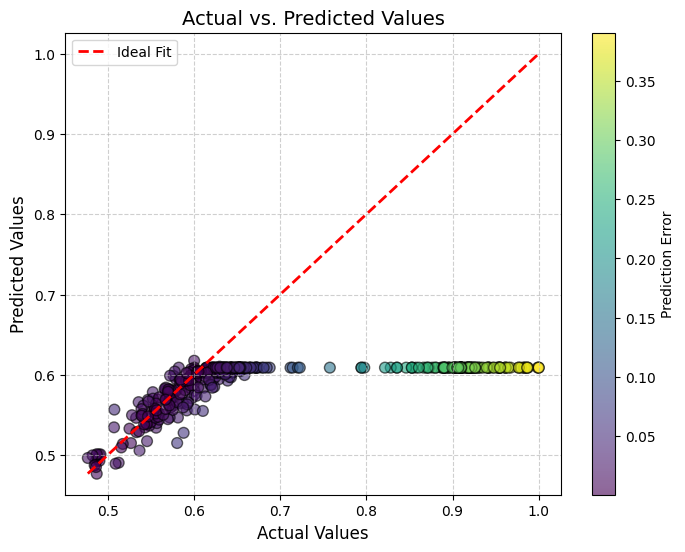

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color gradient based on error magnitude
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 6))  # Set figure size
sc = plt.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.6, edgecolors='k', s=60)

# Plot the ideal diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2, label="Ideal Fit")

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error")

# Labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs. Predicted Values', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


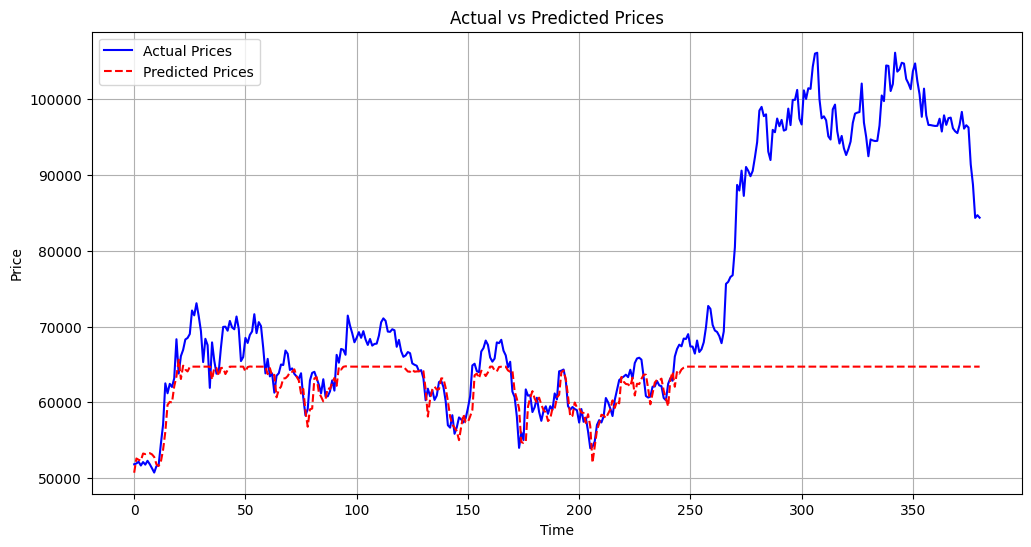

In [ ]:
import matplotlib.pyplot as plt

# Transform predicted and actual values back to the original scale
y_test_inv = Scaler.inverse_transform(
    np.column_stack([y_test, np.zeros((len(y_test), 4))]))[:, 0]
y_pred_best_inv = Scaler.inverse_transform(
    np.column_stack([y_pred, np.zeros((len(y_pred), 4))]))[:, 0]

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_pred_best_inv, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()


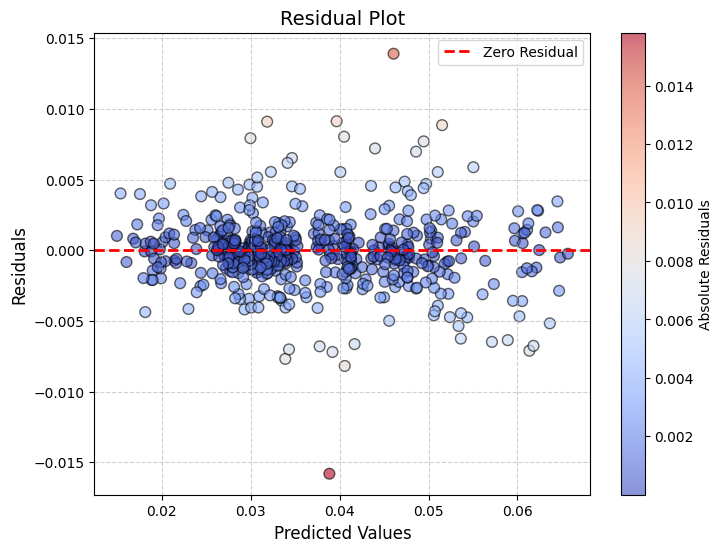

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))  # Set figure size

# Scatter plot with color gradient
sc = plt.scatter(y_pred, residuals, c=np.abs(residuals), cmap='coolwarm', alpha=0.6, edgecolors='k', s=60)

# Horizontal reference line at zero residual
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual")

# Color bar to indicate residual magnitude
cbar = plt.colorbar(sc)
cbar.set_label("Absolute Residuals")

# Labels and title
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

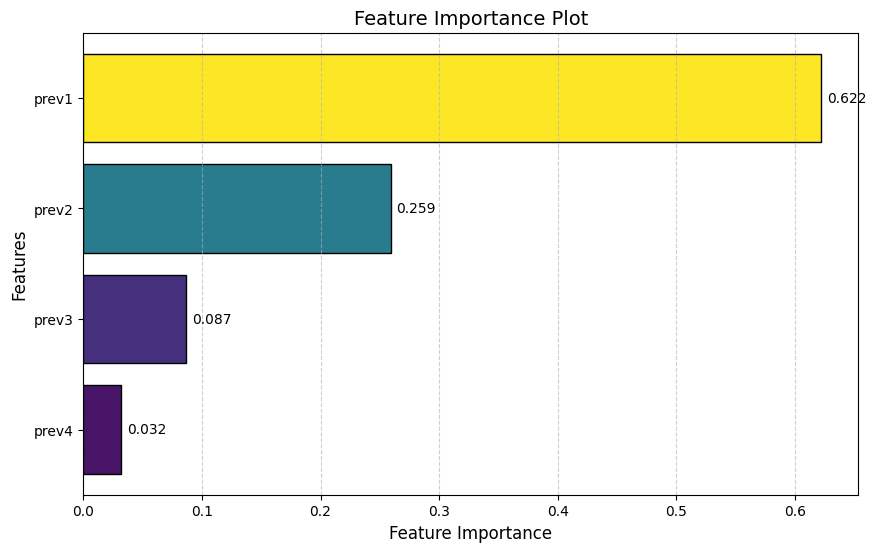

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Feature importances (assuming you have a trained model with feature_importances_)
importances = best_gb.feature_importances_
feature_names = X_train.columns  # Assuming you're using a Pandas DataFrame

# Sort feature importances
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Create figure
plt.figure(figsize=(10, 6))

# Bar plot
colors = plt.cm.viridis(sorted_importances / max(sorted_importances))  # Normalize for colormap
plt.barh(sorted_features, sorted_importances, color=colors, edgecolor='black')

# Add labels
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance Plot', fontsize=14)
plt.gca().invert_yaxis()  # Invert to show most important feature on top

# Add value labels
for i, v in enumerate(sorted_importances):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


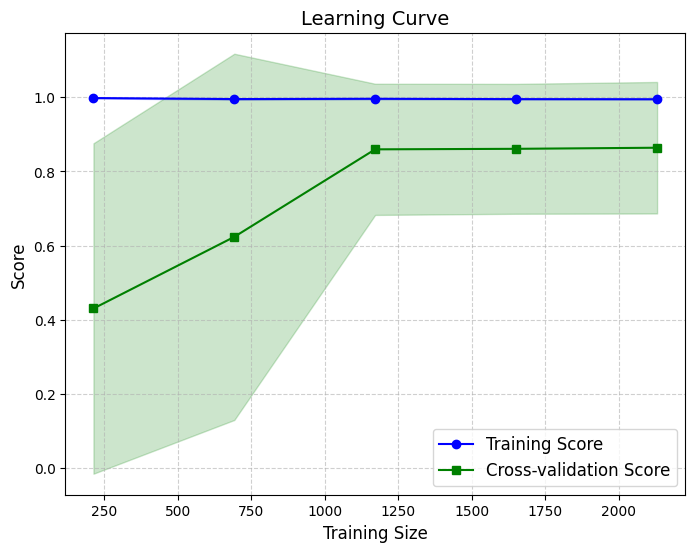

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(best_gb, X_train, y_train, cv=5)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))

# Training score with shading for std deviation
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)

# Cross-validation score with shading
plt.plot(train_sizes, test_mean, 's-', color='green', label='Cross-validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

# Labels and title
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Learning Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


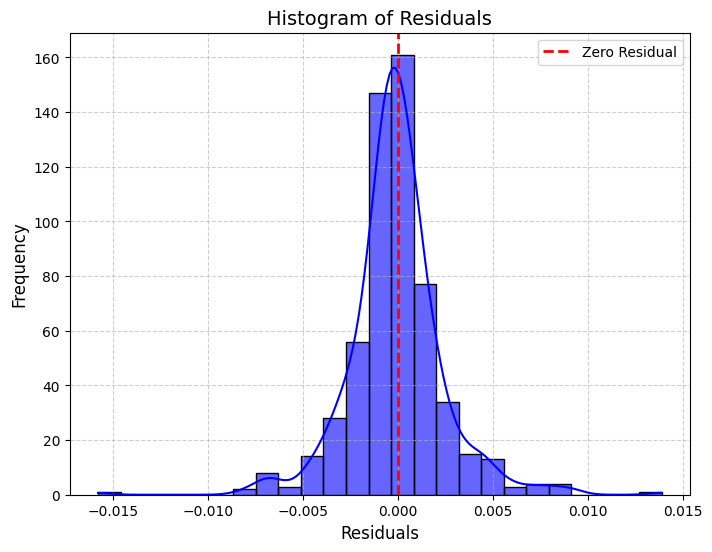

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size
plt.figure(figsize=(8, 6))

# Plot histogram with KDE (density=True makes it comparable)
sns.histplot(residuals, bins=25, kde=True, color='blue', alpha=0.6, edgecolor='black')

# Add vertical line at zero residual
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

# Labels and title
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Residuals', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## **Ensemble**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

# Base models
rfr = rf_best
lr = model_best
gbr = best_gb

# Stacking Regressor with meta-model as Linear Regression
stack = StackingRegressor(
    estimators=[('rfr', rfr), ('lr', lr), ('gbr', gbr)],
)

# Train the stacked model
stacky = stack.fit(X_train, y_train)

# Predict and evaluate
y_pred = stack.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.0035
Root Mean Squared Error: 0.0589
Mean Absolute Error: 0.0402
R-squared: 0.8456


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

# Define base models
base_models = [
    ('rfr', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression()),
    ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
]

# Define Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
)

# Train Stacking Regressor
stacking_regressor.fit(X_train, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test)

stacking_regressor

StackingRegressor(estimators=[('rfr', RandomForestRegressor(random_state=42)),
                              ('lr', LinearRegression()),
                              ('gbr',
                               GradientBoostingRegressor(random_state=42))])

# **DL**

## **LSTM**

In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Sample data (replace with your actual data)
# X = ... (feature matrix)
# y = ... (target variable)

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to 3D array as required by LSTM: [samples, time steps, features]
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized
    n_units = trial.suggest_int('n_units', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    n_batch = trial.suggest_int('n_batch', 16, 128)
    n_epochs = 20  # Fixed number of epochs for simplicity

    # Initialize LSTM model
    model = Sequential()
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=n_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)

    # Predict prices on testing data
    y_pred = model.predict(X_val)

    # Compute performance metric (RMSE in this case)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-04-18 03:09:49,799] A new study created in memory with name: no-name-c8278c1c-edc3-4173-8319-71e703be372a
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-04-18 03:10:39,683] Trial 0 finished with value: 0.008564435376484467 and parameters: {'n_units': 98, 'learning_rate': 0.0006765310420860259, 'dropout_rate': 0.26814147022692186, 'n_batch': 118}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2025-04-18 03:11:36,350] Trial 1 finished with value: 0.01114050314282809 and parameters: {'n_units': 71, 'learning_rate': 0.0008502237397793906, 'dropout_rate': 0.3399847617404701, 'n_batch': 22}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step


[I 2025-04-18 03:13:25,115] Trial 2 finished with value: 0.01625371944022823 and parameters: {'n_units': 92, 'learning_rate': 0.0007497306335514558, 'dropout_rate': 0.37393752473095876, 'n_batch': 66}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2025-04-18 03:14:16,215] Trial 3 finished with value: 0.008859209580405356 and parameters: {'n_units': 89, 'learning_rate': 0.0003093467832043907, 'dropout_rate': 0.17427393114920997, 'n_batch': 93}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2025-04-18 03:14:34,358] Trial 4 finished with value: 0.027124192455154537 and parameters: {'n_units': 15, 'learning_rate': 0.00026441690291109486, 'dropout_rate': 0.42909318116641726, 'n_batch': 93}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2025-04-18 03:15:23,786] Trial 5 finished with value: 0.013209144716229299 and parameters: {'n_units': 42, 'learning_rate': 0.00033565574955235283, 'dropout_rate': 0.26872537279738995, 'n_batch': 24}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2025-04-18 03:16:12,017] Trial 6 finished with value: 0.008974314821584414 and parameters: {'n_units': 62, 'learning_rate': 0.0019529608543590554, 'dropout_rate': 0.40143487314750126, 'n_batch': 30}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2025-04-18 03:16:29,019] Trial 7 finished with value: 0.008950396437603803 and parameters: {'n_units': 26, 'learning_rate': 0.004662527817977954, 'dropout_rate': 0.2179001078184722, 'n_batch': 119}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2025-04-18 03:17:08,516] Trial 8 finished with value: 0.012064127104781332 and parameters: {'n_units': 65, 'learning_rate': 0.0008884010013007842, 'dropout_rate': 0.42640009517646416, 'n_batch': 40}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2025-04-18 03:17:31,281] Trial 9 finished with value: 0.013927128637673905 and parameters: {'n_units': 51, 'learning_rate': 0.00029442579540469026, 'dropout_rate': 0.2661090368449097, 'n_batch': 128}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


[I 2025-04-18 03:18:19,998] Trial 10 finished with value: 0.013419420638753387 and parameters: {'n_units': 98, 'learning_rate': 0.00010021639808760753, 'dropout_rate': 0.11467687146203293, 'n_batch': 99}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


[I 2025-04-18 03:19:03,651] Trial 11 finished with value: 0.008847067775957269 and parameters: {'n_units': 84, 'learning_rate': 0.00013147786337725724, 'dropout_rate': 0.1611597962230908, 'n_batch': 99}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-04-18 03:19:39,556] Trial 12 finished with value: 0.011735160626346124 and parameters: {'n_units': 80, 'learning_rate': 0.00975352919528409, 'dropout_rate': 0.10262850496518224, 'n_batch': 111}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2025-04-18 03:20:31,348] Trial 13 finished with value: 0.013814030333460344 and parameters: {'n_units': 80, 'learning_rate': 0.00010636328405843084, 'dropout_rate': 0.19847337731465423, 'n_batch': 71}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2025-04-18 03:21:11,728] Trial 14 finished with value: 0.029221117804583988 and parameters: {'n_units': 81, 'learning_rate': 0.0019800483726971872, 'dropout_rate': 0.3141641541516687, 'n_batch': 104}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2025-04-18 03:22:11,034] Trial 15 finished with value: 0.02337826379966244 and parameters: {'n_units': 99, 'learning_rate': 0.00018643997763395144, 'dropout_rate': 0.4879263950798551, 'n_batch': 85}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2025-04-18 03:22:42,057] Trial 16 finished with value: 0.009621345802897965 and parameters: {'n_units': 47, 'learning_rate': 0.0005417968791848314, 'dropout_rate': 0.15199605789026005, 'n_batch': 53}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2025-04-18 03:23:32,813] Trial 17 finished with value: 0.01285047060045005 and parameters: {'n_units': 87, 'learning_rate': 0.0015372076239260164, 'dropout_rate': 0.24903565204469413, 'n_batch': 81}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2025-04-18 03:24:05,009] Trial 18 finished with value: 0.014405407519641075 and parameters: {'n_units': 70, 'learning_rate': 0.00017163482796932203, 'dropout_rate': 0.1535120326131636, 'n_batch': 116}. Best is trial 0 with value: 0.008564435376484467.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2025-04-18 03:24:57,191] Trial 19 finished with value: 0.022474606549132033 and parameters: {'n_units': 100, 'learning_rate': 0.000499012994962432, 'dropout_rate': 0.2174683920655265, 'n_batch': 127}. Best is trial 0 with value: 0.008564435376484467.


In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Get the best hyperparameters
best_params = study.best_params
# Reshape the input data to 3D array as required by LSTM: [samples, time steps, features]

# Train the model with the best hyperparameters
best_model = Sequential()
best_model.add(LSTM(units=best_params['n_units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(LSTM(units=best_params['n_units']))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(1))

# Compile model
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

# Train model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=best_params['n_batch'], validation_data=(X_test, y_test))

# Predict prices on testing data
y_pred = best_model.predict(X_test)

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Compute TWAP and VWAP performance metrics (for illustration purposes, using random weights)
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred.flatten() * weights) / np.sum(weights)
vwap = np.sum(y_pred.flatten() * y_test) / np.sum(y_test)

# Return LSTM model performance metrics
performance_metrics_LSTM = {
    'RMSE': rmse,
    'MSE': mse,
    'MAE': mae,
    'R2': r2,
    'TWAP': twap,
    'VWAP': vwap
}

print('Performance Metrics:', performance_metrics_LSTM)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0607 - val_loss: 0.2337
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0241 - val_loss: 0.0034
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0078 - val_loss: 9.4575e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0048 - val_loss: 6.2759e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0035 - val_loss: 6.1068e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0031 - val_loss: 9.2841e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0024 - val_loss: 9.4584e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0023 - val_loss: 7.3869e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0016 - val_loss: 9.5310e-04
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1]))

In [ ]:
y_pred = y_pred.reshape(y_test.shape)

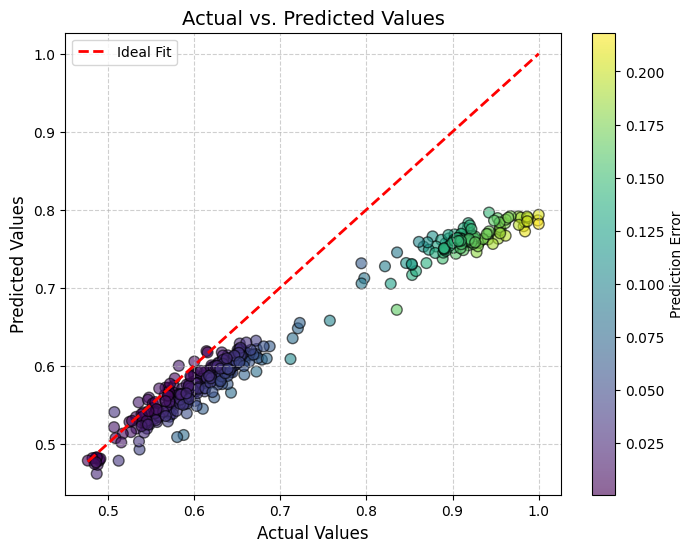

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color gradient based on error magnitude
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 6))  # Set figure size
sc = plt.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.6, edgecolors='k', s=60)

# Plot the ideal diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2, label="Ideal Fit")

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error")

# Labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs. Predicted Values', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


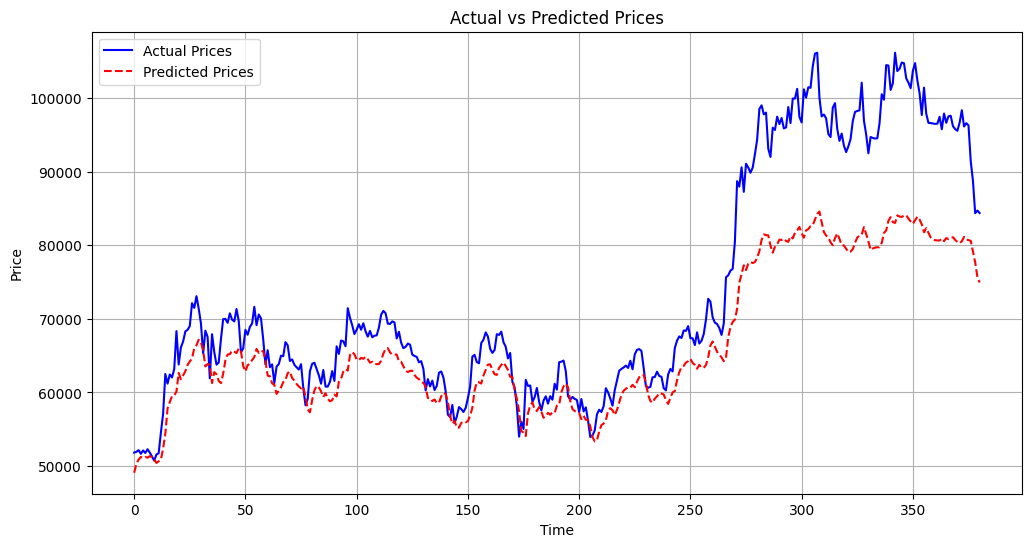

In [ ]:
# Ensure you use the same scaler that was used for fitting
y_test_inv = Scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_pred_lstm_inv = Scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Plot Actual vs Predicted Prices for LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_pred_lstm_inv, label="Predicted Prices", color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()

plt.show()


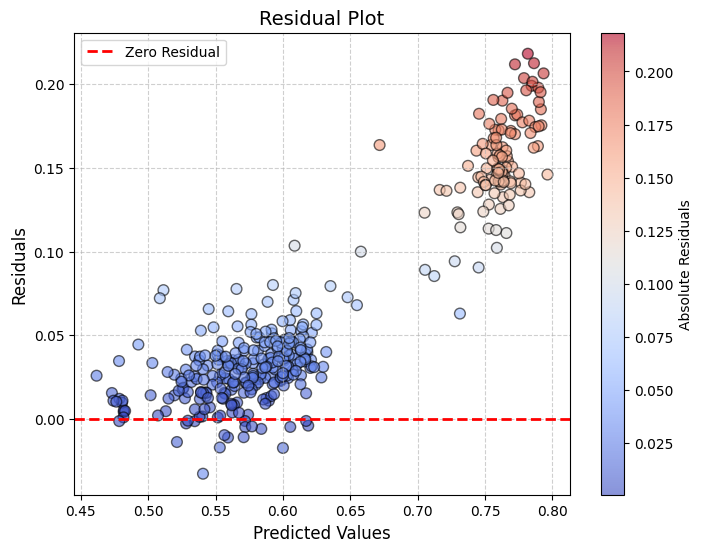

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))  # Set figure size

# Scatter plot with color gradient
sc = plt.scatter(y_pred, residuals, c=np.abs(residuals), cmap='coolwarm', alpha=0.6, edgecolors='k', s=60)

# Horizontal reference line at zero residual
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual")

# Color bar to indicate residual magnitude
cbar = plt.colorbar(sc)
cbar.set_label("Absolute Residuals")

# Labels and title
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

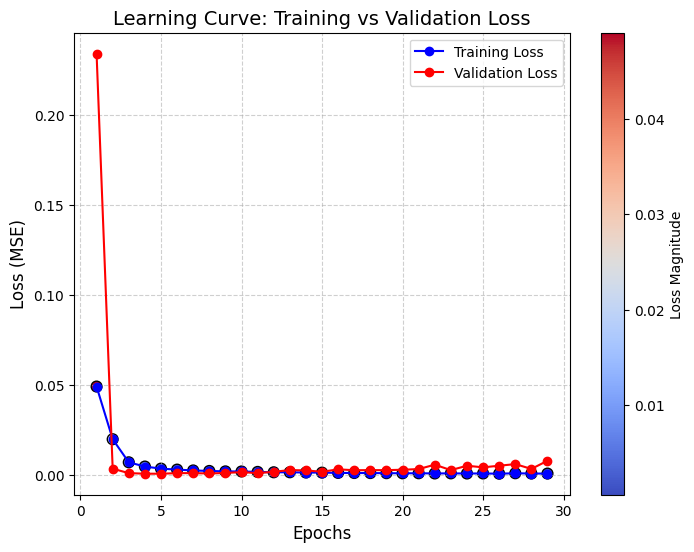

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochh = 30

def plot_learning_curve(history):
    plt.figure(figsize=(8, 6))  # Set figure size
    epochs = range(1, epochh) #len(history.history['loss']) + 1)

    # Plot training and validation loss with improved aesthetics
    plt.plot(epochs, history.history['loss'][:epochh-1], 'bo-', label='Training Loss', markersize=6)
    plt.plot(epochs, history.history['val_loss'][:epochh-1], 'ro-', label='Validation Loss', markersize=6)

    # Scatter points with color gradient based on loss magnitude
    sc = plt.scatter(epochs, history.history['loss'][:epochh-1], c=np.abs(history.history['loss'][:epochh-1]), cmap='coolwarm', edgecolors='k', s=60)

    # Color bar to indicate loss magnitude
    cbar = plt.colorbar(sc)
    cbar.set_label("Loss Magnitude")

    # Labels, title, and grid for better visualization
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('Learning Curve: Training vs Validation Loss', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(history)  # Uncomment when 'history' is available

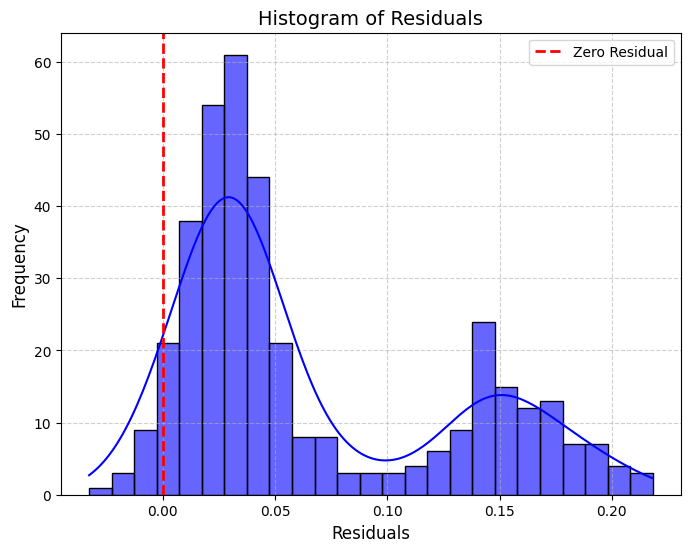

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size
plt.figure(figsize=(8, 6))

# Plot histogram with KDE (density=True makes it comparable)
sns.histplot(residuals, bins=25, kde=True, color='blue', alpha=0.6, edgecolor='black')

# Add vertical line at zero residual
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

# Labels and title
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Residuals', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## **MLP**

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Assume X and y are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_int("n_units", 10, 200)
    n_epochs = trial.suggest_int("n_epochs", 10, 100)
    n_batch = trial.suggest_categorical("n_batch", [16, 32, 64])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Initialize MLP model
    model = Sequential()
    model.add(Flatten(input_shape=(X_train.shape[1],)))  # Flatten input if necessary
    for _ in range(n_layers):
        model.add(Dense(units=n_units, activation='relu'))
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)

    # Predict on validation set
    y_pred = model.predict(X_test)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse  # Optuna will minimize RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best parameters found
print("Best hyperparameters:", study.best_params)

[I 2025-04-18 03:45:02,464] A new study created in memory with name: no-name-f907e8a8-75d2-4854-9964-2055fc2571f1
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:45:13,812] Trial 0 finished with value: 125.05162643356304 and parameters: {'n_layers': 3, 'n_units': 86, 'n_epochs': 32, 'n_batch': 64, 'learning_rate': 1.6296682993377987e-05}. Best is trial 0 with value: 125.05162643356304.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-04-18 03:45:34,211] Trial 1 finished with value: 40.635002193731346 and parameters: {'n_layers': 3, 'n_units': 93, 'n_epochs': 28, 'n_batch': 16, 'learning_rate': 0.0004065060711063769}. Best is trial 1 with value: 40.635002193731346.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-18 03:45:43,170] Trial 2 finished with value: 51.44258261853627 and parameters: {'n_layers': 2, 'n_units': 146, 'n_epochs': 27, 'n_batch': 64, 'learning_rate': 0.00042745972205106454}. Best is trial 1 with value: 40.635002193731346.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-18 03:46:27,060] Trial 3 finished with value: 144.5814653729367 and parameters: {'n_layers': 1, 'n_units': 146, 'n_epochs': 71, 'n_batch': 16, 'learning_rate': 3.329959570503149e-05}. Best is trial 1 with value: 40.635002193731346.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-18 03:46:38,014] Trial 4 finished with value: 47.91376912640626 and parameters: {'n_layers': 1, 'n_units': 154, 'n_epochs': 29, 'n_batch': 32, 'learning_rate': 7.907291642452125e-05}. Best is trial 1 with value: 40.635002193731346.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2025-04-18 03:47:08,771] Trial 5 finished with value: 12.144506555534429 and parameters: {'n_layers': 3, 'n_units': 49, 'n_epochs': 79, 'n_batch': 32, 'learning_rate': 0.00014677643240345957}. Best is trial 5 with value: 12.144506555534429.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:47:29,210] Trial 6 finished with value: 49.79696076232482 and parameters: {'n_layers': 2, 'n_units': 131, 'n_epochs': 63, 'n_batch': 64, 'learning_rate': 0.000687879149854259}. Best is trial 5 with value: 12.144506555534429.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:47:48,875] Trial 7 finished with value: 11.116206307407593 and parameters: {'n_layers': 3, 'n_units': 199, 'n_epochs': 48, 'n_batch': 64, 'learning_rate': 0.007267784172896928}. Best is trial 7 with value: 11.116206307407593.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 03:48:06,202] Trial 8 finished with value: 486.05550815846397 and parameters: {'n_layers': 1, 'n_units': 28, 'n_epochs': 52, 'n_batch': 32, 'learning_rate': 0.0003096959618520701}. Best is trial 7 with value: 11.116206307407593.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:49:12,197] Trial 9 finished with value: 3.092805451222737 and parameters: {'n_layers': 3, 'n_units': 148, 'n_epochs': 97, 'n_batch': 16, 'learning_rate': 1.5705824819434158e-05}. Best is trial 9 with value: 3.092805451222737.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-18 03:50:18,597] Trial 10 finished with value: 7.3247961530326835 and parameters: {'n_layers': 2, 'n_units': 185, 'n_epochs': 98, 'n_batch': 16, 'learning_rate': 1.1931993306710965e-05}. Best is trial 9 with value: 3.092805451222737.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:51:24,985] Trial 11 finished with value: 61.40363136135432 and parameters: {'n_layers': 2, 'n_units': 200, 'n_epochs': 100, 'n_batch': 16, 'learning_rate': 1.0246431550612363e-05}. Best is trial 9 with value: 3.092805451222737.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-18 03:52:30,683] Trial 12 finished with value: 6.986702492551479 and parameters: {'n_layers': 2, 'n_units': 176, 'n_epochs': 100, 'n_batch': 16, 'learning_rate': 4.990396961486013e-05}. Best is trial 9 with value: 3.092805451222737.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 03:53:28,888] Trial 13 finished with value: 12.532633473950055 and parameters: {'n_layers': 2, 'n_units': 169, 'n_epochs': 86, 'n_batch': 16, 'learning_rate': 4.15136317761997e-05}. Best is trial 9 with value: 3.092805451222737.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:54:25,974] Trial 14 finished with value: 30.02235158340236 and parameters: {'n_layers': 3, 'n_units': 120, 'n_epochs': 84, 'n_batch': 16, 'learning_rate': 3.7135374725482465e-05}. Best is trial 9 with value: 3.092805451222737.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:55:27,813] Trial 15 finished with value: 0.9807274259625238 and parameters: {'n_layers': 2, 'n_units': 169, 'n_epochs': 94, 'n_batch': 16, 'learning_rate': 0.001612376408217579}. Best is trial 15 with value: 0.9807274259625238.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 03:55:36,675] Trial 16 finished with value: 14.791302169509636 and parameters: {'n_layers': 3, 'n_units': 107, 'n_epochs': 10, 'n_batch': 16, 'learning_rate': 0.0028048281200180134}. Best is trial 15 with value: 0.9807274259625238.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-18 03:56:31,338] Trial 17 finished with value: 44.642770569998014 and parameters: {'n_layers': 1, 'n_units': 75, 'n_epochs': 88, 'n_batch': 16, 'learning_rate': 0.0011760294713322225}. Best is trial 15 with value: 0.9807274259625238.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 03:57:20,717] Trial 18 finished with value: 0.22016502566143975 and parameters: {'n_layers': 2, 'n_units': 158, 'n_epochs': 73, 'n_batch': 16, 'learning_rate': 0.002117267122215432}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 03:57:52,804] Trial 19 finished with value: 36.479424709971426 and parameters: {'n_layers': 2, 'n_units': 167, 'n_epochs': 71, 'n_batch': 32, 'learning_rate': 0.0025399430636269325}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-04-18 03:58:34,075] Trial 20 finished with value: 1.4773632267934784 and parameters: {'n_layers': 2, 'n_units': 125, 'n_epochs': 61, 'n_batch': 16, 'learning_rate': 0.007688320373569201}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[I 2025-04-18 03:59:15,058] Trial 21 finished with value: 1.4462716258689232 and parameters: {'n_layers': 2, 'n_units': 125, 'n_epochs': 61, 'n_batch': 16, 'learning_rate': 0.009649627248240535}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 03:59:43,363] Trial 22 finished with value: 9.501378338991923 and parameters: {'n_layers': 2, 'n_units': 131, 'n_epochs': 45, 'n_batch': 16, 'learning_rate': 0.0032447338913704177}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 04:00:30,652] Trial 23 finished with value: 8.892534923115509 and parameters: {'n_layers': 2, 'n_units': 156, 'n_epochs': 72, 'n_batch': 16, 'learning_rate': 0.0014094739934031083}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 04:01:10,017] Trial 24 finished with value: 0.5870700279206933 and parameters: {'n_layers': 2, 'n_units': 108, 'n_epochs': 60, 'n_batch': 16, 'learning_rate': 0.005283720077957793}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-18 04:01:54,967] Trial 25 finished with value: 1.539575354943224 and parameters: {'n_layers': 1, 'n_units': 66, 'n_epochs': 76, 'n_batch': 16, 'learning_rate': 0.004027071491230371}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-18 04:02:37,181] Trial 26 finished with value: 44.29393705232596 and parameters: {'n_layers': 2, 'n_units': 10, 'n_epochs': 65, 'n_batch': 16, 'learning_rate': 0.001515443675719534}. Best is trial 18 with value: 0.22016502566143975.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:03:40,426] Trial 27 finished with value: 0.09920380604941738 and parameters: {'n_layers': 2, 'n_units': 105, 'n_epochs': 91, 'n_batch': 16, 'learning_rate': 0.005052696626862692}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-18 04:03:57,096] Trial 28 finished with value: 65.49990751468228 and parameters: {'n_layers': 1, 'n_units': 96, 'n_epochs': 42, 'n_batch': 32, 'learning_rate': 0.005088282098401964}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:04:22,720] Trial 29 finished with value: 122.54799777138389 and parameters: {'n_layers': 2, 'n_units': 110, 'n_epochs': 79, 'n_batch': 64, 'learning_rate': 0.0051282411151556285}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:04:51,968] Trial 30 finished with value: 15.673835296359817 and parameters: {'n_layers': 2, 'n_units': 77, 'n_epochs': 91, 'n_batch': 64, 'learning_rate': 0.000723076855105953}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-04-18 04:05:56,156] Trial 31 finished with value: 0.22067331918672875 and parameters: {'n_layers': 2, 'n_units': 183, 'n_epochs': 92, 'n_batch': 16, 'learning_rate': 0.0020644980446715296}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 04:06:53,026] Trial 32 finished with value: 0.7651273232949338 and parameters: {'n_layers': 2, 'n_units': 185, 'n_epochs': 84, 'n_batch': 16, 'learning_rate': 0.0023165822053953793}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-04-18 04:07:54,785] Trial 33 finished with value: 17.82951457361532 and parameters: {'n_layers': 2, 'n_units': 86, 'n_epochs': 92, 'n_batch': 16, 'learning_rate': 0.0008500336121203573}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-04-18 04:08:29,915] Trial 34 finished with value: 5.953737971952807 and parameters: {'n_layers': 2, 'n_units': 56, 'n_epochs': 56, 'n_batch': 16, 'learning_rate': 0.005156259962005987}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:09:21,949] Trial 35 finished with value: 0.5845102046250334 and parameters: {'n_layers': 3, 'n_units': 97, 'n_epochs': 76, 'n_batch': 16, 'learning_rate': 0.002008477130834779}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:10:15,111] Trial 36 finished with value: 3.9865600584546796 and parameters: {'n_layers': 3, 'n_units': 98, 'n_epochs': 80, 'n_batch': 16, 'learning_rate': 0.00037116014038791277}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:10:38,190] Trial 37 finished with value: 172.4947107235993 and parameters: {'n_layers': 3, 'n_units': 143, 'n_epochs': 73, 'n_batch': 64, 'learning_rate': 0.00018232726686495988}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:11:10,697] Trial 38 finished with value: 6.687004209690304 and parameters: {'n_layers': 3, 'n_units': 84, 'n_epochs': 68, 'n_batch': 32, 'learning_rate': 0.0021321710629551905}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-18 04:12:04,827] Trial 39 finished with value: 25.777790165338754 and parameters: {'n_layers': 1, 'n_units': 186, 'n_epochs': 89, 'n_batch': 16, 'learning_rate': 0.0005096282788872255}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-18 04:12:59,390] Trial 40 finished with value: 0.7363625153980774 and parameters: {'n_layers': 3, 'n_units': 115, 'n_epochs': 82, 'n_batch': 16, 'learning_rate': 0.0010475269998074337}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2025-04-18 04:13:49,906] Trial 41 finished with value: 0.5977120436042682 and parameters: {'n_layers': 2, 'n_units': 139, 'n_epochs': 77, 'n_batch': 16, 'learning_rate': 0.003634103245150281}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-18 04:14:27,917] Trial 42 finished with value: 6.056347294778139 and parameters: {'n_layers': 2, 'n_units': 101, 'n_epochs': 56, 'n_batch': 16, 'learning_rate': 0.001925846944611717}. Best is trial 27 with value: 0.09920380604941738.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Train final model with best hyperparameters
best_params = {'n_layers': 2, 'n_units': 142, 'n_epochs': 34, 'n_batch': 64, 'learning_rate': 4.7881727712496786e-05}
best_model = Sequential()
best_model.add(Flatten(input_shape=(X_train.shape[1],)))
for _ in range(best_params["n_layers"]):
    best_model.add(Dense(units=best_params["n_units"], activation='relu'))
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss='mean_squared_error')
history = best_model.fit(X_train, y_train, epochs=best_params["n_epochs"], batch_size=best_params["n_batch"], validation_data=(X_test, y_test))

# Predictions & Performance Metrics
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Compute TWAP and VWAP performance metrics
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred.flatten() * weights) / np.sum(weights)
vwap = np.sum(y_pred.flatten() * y_test) / np.sum(y_test)

performance_metrics_MLP = {
    'RMSE': rmse,
    'MSE': mse,
    'MAE': mae,
    'R2': r2,
    'TWAP': twap,
    'VWAP': vwap
}

print(performance_metrics_MLP)

## **GRU**

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Assume X and y are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Suggest hyperparameters
    n_units = trial.suggest_int("n_units", 10, 200)
    n_epochs = trial.suggest_int("n_epochs", 10, 100)
    n_batch = trial.suggest_categorical("n_batch", [16, 32, 64])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Initialize GRU model
    model = Sequential()
    model.add(GRU(units=n_units, return_sequences=True, input_shape=(3, 1)))
    model.add(GRU(units=n_units))
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)

    # Predict on validation set
    y_pred = model.predict(X_test)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse  # Optuna will minimize RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)  # Increased n_trials for better tuning

# Best parameters found
print("Best hyperparameters:", study.best_params)

[I 2025-04-24 04:05:15,450] A new study created in memory with name: no-name-a79facf2-28d9-4cd4-bc82-3ec16ffe258c
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2025-04-24 04:06:04,251] Trial 0 finished with value: 0.07716858465314927 and parameters: {'n_units': 67, 'n_epochs': 35, 'n_batch': 64, 'learning_rate': 0.002003134282150196}. Best is trial 0 with value: 0.07716858465314927.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2025-04-24 04:07:57,717] Trial 1 finished with value: 0.049686515316157726 and parameters: {'n_units': 50, 'n_epochs': 78, 'n_batch': 32, 'learning_rate': 0.0004456872952367571}. Best is trial 1 with value: 0.049686515316157726.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-04-24 04:16:26,120] Trial 2 finished with value: 0.028093092933681625 and parameters: {'n_units': 192, 'n_epochs': 81, 'n_batch': 32, 'learning_rate': 1.2011621521971109e-05}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2025-04-24 04:20:29,588] Trial 3 finished with value: 0.02841174226555924 and parameters: {'n_units': 136, 'n_epochs': 56, 'n_batch': 16, 'learning_rate': 1.664533405979651e-05}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2025-04-24 04:22:58,672] Trial 4 finished with value: 0.05330187265968225 and parameters: {'n_units': 115, 'n_epochs': 35, 'n_batch': 16, 'learning_rate': 0.006177630864894209}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[I 2025-04-24 04:25:06,648] Trial 5 finished with value: 0.03299203581061012 and parameters: {'n_units': 66, 'n_epochs': 84, 'n_batch': 32, 'learning_rate': 1.547268665450124e-05}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2025-04-24 04:26:33,984] Trial 6 finished with value: 0.036800651191846494 and parameters: {'n_units': 196, 'n_epochs': 17, 'n_batch': 64, 'learning_rate': 0.0005285240293810613}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2025-04-24 04:27:52,845] Trial 7 finished with value: 0.08738280381072866 and parameters: {'n_units': 22, 'n_epochs': 27, 'n_batch': 16, 'learning_rate': 0.0019247382034382492}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


[I 2025-04-24 04:29:12,902] Trial 8 finished with value: 0.04652981446279722 and parameters: {'n_units': 33, 'n_epochs': 26, 'n_batch': 16, 'learning_rate': 0.0010420558447686145}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


[I 2025-04-24 04:36:03,499] Trial 9 finished with value: 0.03827605457211373 and parameters: {'n_units': 162, 'n_epochs': 92, 'n_batch': 32, 'learning_rate': 0.00012799266359533548}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2025-04-24 04:42:13,622] Trial 10 finished with value: 0.02910879103388318 and parameters: {'n_units': 190, 'n_epochs': 64, 'n_batch': 32, 'learning_rate': 6.99887098540763e-05}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2025-04-24 04:46:13,945] Trial 11 finished with value: 0.031627163440242155 and parameters: {'n_units': 139, 'n_epochs': 56, 'n_batch': 16, 'learning_rate': 1.0049932677674216e-05}. Best is trial 2 with value: 0.028093092933681625.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2025-04-24 04:53:43,924] Trial 12 finished with value: 0.02616220453167402 and parameters: {'n_units': 158, 'n_epochs': 100, 'n_batch': 32, 'learning_rate': 3.672675189965258e-05}. Best is trial 12 with value: 0.02616220453167402.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2025-04-24 05:01:17,655] Trial 13 finished with value: 0.025023798427727142 and parameters: {'n_units': 166, 'n_epochs': 100, 'n_batch': 32, 'learning_rate': 4.7535183392879975e-05}. Best is trial 13 with value: 0.025023798427727142.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Reshape the input data to 3D array as required by LSTM: [samples, time steps, features]
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

# Train final model with best hyperparameters
best_params = study.best_params
best_model = Sequential()
best_model.add(GRU(units=best_params["n_units"], return_sequences=True, input_shape=(3, 1)))
best_model.add(GRU(units=best_params["n_units"]))
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss='mean_squared_error')
history = best_model.fit(X_train, y_train, epochs=best_params["n_epochs"], batch_size=best_params["n_batch"], validation_data=(X_test, y_test))

# Predictions & Performance Metrics
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Compute TWAP and VWAP performance metrics
weights = np.random.rand(len(y_test))
twap = np.sum(y_pred_best.flatten() * weights) / np.sum(weights)
vwap = np.sum(y_pred_best.flatten() * y_test) / np.sum(y_test)

performance_metrics_GRU = {
    'RMSE': rmse,
    'MSE': mse,
    'MAE': mae,
    'R2': r2,
    'TWAP': twap,
    'VWAP': vwap
}

print(performance_metrics_GRU)


NameError: name 'GRU' is not defined

In [ ]:
y_pred_best = y_pred_best.reshape(y_test.shape)

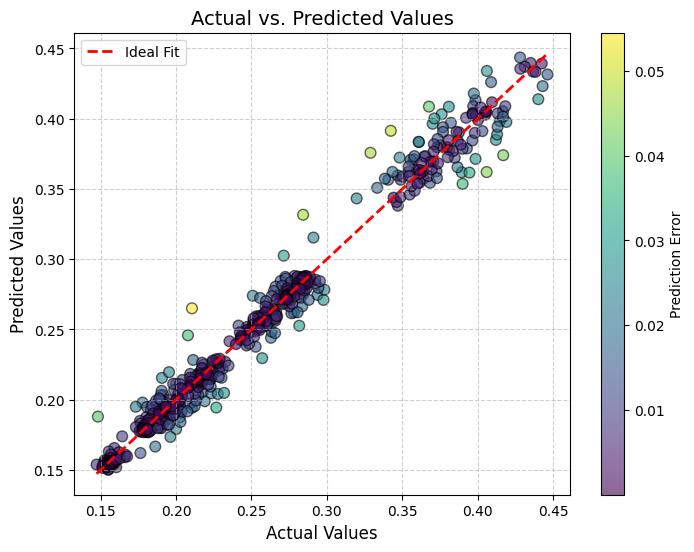

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color gradient based on error magnitude
errors = np.abs(y_test - y_pred_best)

plt.figure(figsize=(8, 6))  # Set figure size
sc = plt.scatter(y_test, y_pred_best, c=errors, cmap='viridis', alpha=0.6, edgecolors='k', s=60)

# Plot the ideal diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2, label="Ideal Fit")

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error")

# Labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs. Predicted Values', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


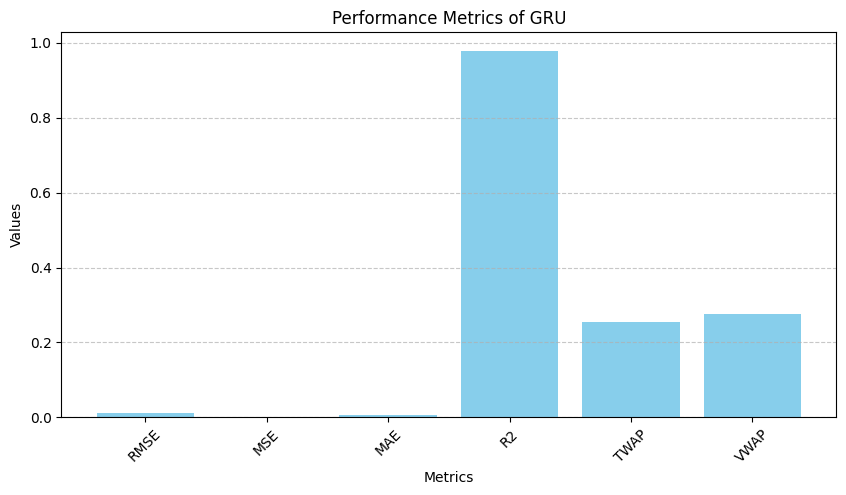

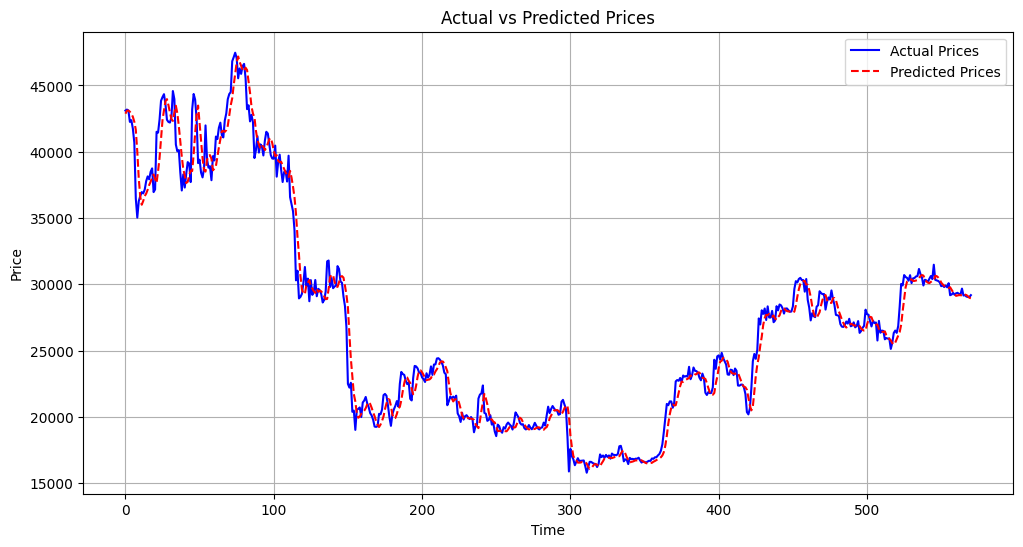

In [ ]:
import matplotlib.pyplot as plt

# Plot Performance Metrics as Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(performance_metrics_GRU.keys(), performance_metrics_GRU.values(), color='skyblue')
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Performance Metrics of GRU")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Transform predicted and actual values back to the original scale
y_test_inv = Scaler.inverse_transform(
    np.column_stack([y_test, np.zeros((len(y_test), 4))]))[:, 0]
y_pred_best_inv = Scaler.inverse_transform(
    np.column_stack([y_pred_best, np.zeros((len(y_pred_best), 4))]))[:, 0]

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_pred_best_inv, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()


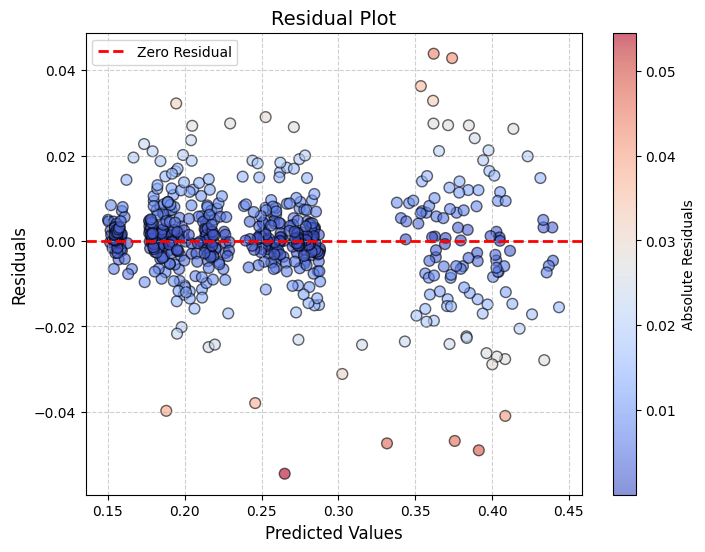

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(8, 6))  # Set figure size

# Scatter plot with color gradient
sc = plt.scatter(y_pred_best, residuals, c=np.abs(residuals), cmap='coolwarm', alpha=0.6, edgecolors='k', s=60)

# Horizontal reference line at zero residual
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual")

# Color bar to indicate residual magnitude
cbar = plt.colorbar(sc)
cbar.set_label("Absolute Residuals")

# Labels and title
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Feature importances (assuming you have a trained model with feature_importances_)
importances = model_best.feature_importances_
feature_names = X_train.columns  # Assuming you're using a Pandas DataFrame

# Sort feature importances
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Create figure
plt.figure(figsize=(10, 6))

# Bar plot
colors = plt.cm.viridis(sorted_importances / max(sorted_importances))  # Normalize for colormap
plt.barh(sorted_features, sorted_importances, color=colors, edgecolor='black')

# Add labels
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance Plot', fontsize=14)
plt.gca().invert_yaxis()  # Invert to show most important feature on top

# Add value labels
for i, v in enumerate(sorted_importances):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


AttributeError: 'Sequential' object has no attribute 'feature_importances_'

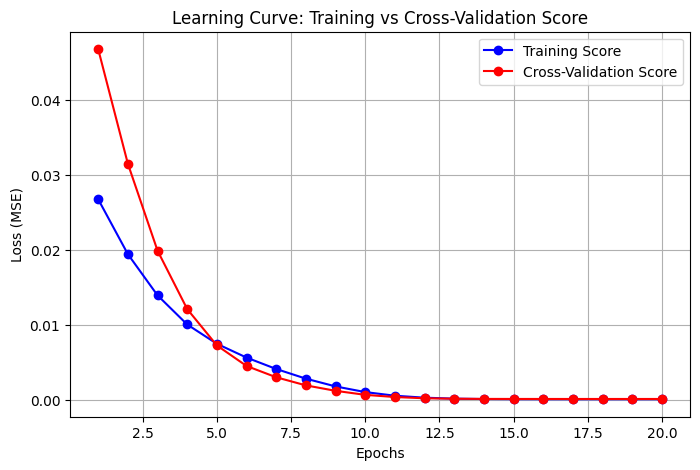

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 5))

    epochs = range(1, 21)

    # Plot training and validation loss
    plt.plot(epochs[:20], history.history['loss'][:20], 'bo-', label='Training Score')   # Blue line
    plt.plot(epochs[:20], history.history['val_loss'][:20], 'ro-', label='Cross-Validation Score')  # Red line

    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Learning Curve: Training vs Cross-Validation Score')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(historyg)

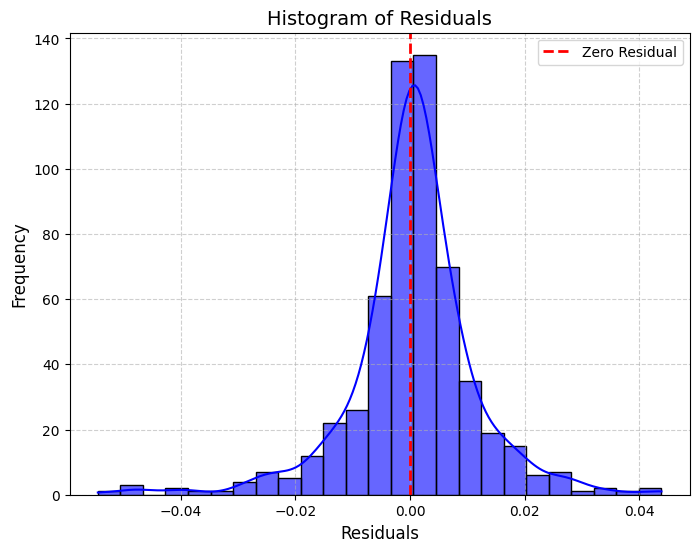

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size
plt.figure(figsize=(8, 6))

# Plot histogram with KDE (density=True makes it comparable)
sns.histplot(residuals, bins=25, kde=True, color='blue', alpha=0.6, edgecolor='black')

# Add vertical line at zero residual
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

# Labels and title
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Residuals', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

# **Monte Carlo Method**

## **Import all Dependencies**

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
from datetime import datetime, timedelta
import statistics as st

## **Import Stock Data**

In [ ]:
def full_data(ticker):
  return yf.Ticker(ticker).history(start="2020-03-01",end="2025-03-01")

In [ ]:
data = full_data('BTC-USD')

## **Daily Log Returns**

In [ ]:
def log_returns(stock_data):
  return np.log(1 + stock_data['Close'].pct_change())[1:]

In [ ]:
lr = log_returns(data)

In [ ]:
lr

Date
2020-03-02 00:00:00+00:00    0.035251
2020-03-03 00:00:00+00:00   -0.009275
2020-03-04 00:00:00+00:00   -0.003710
2020-03-05 00:00:00+00:00    0.036285
2020-03-06 00:00:00+00:00    0.004811
                               ...   
2025-02-24 00:00:00+00:00   -0.051753
2025-02-25 00:00:00+00:00   -0.029777
2025-02-26 00:00:00+00:00   -0.050728
2025-02-27 00:00:00+00:00    0.004226
2025-02-28 00:00:00+00:00   -0.003918
Name: Close, Length: 1825, dtype: float64

## **Truncating the data**

In [ ]:
def truncate(data, end, window):
  return data[end-window:end]

## **Looping the truncation for model**

In [ ]:
start = "2024-01-01"
end = "2025-01-01"
window = 4
num_sim = 10000
num_days = 1

In [ ]:
start_index = data.index.get_loc(start)
end_index = data.index.get_loc(end)

In [ ]:
prob = []
for end in range(start_index, end_index-num_days,num_days):
  trunc_data = truncate(lr, end, window)
  vol = np.std(trunc_data)
  all_simulations = []
  for x in range(num_sim):
    prices = [truncate(data, end, window)["Close"].iloc[-1]]
    for y in range(1, num_days):
      prices.append(prices[-1] * (1 + np.random.normal(0, vol)))
    all_simulations.append(prices)
  Simulation = pd.DataFrame(all_simulations).transpose().iloc[-1]
  avg = st.mean(Simulation)
  print(avg)

42265.1875
44167.33203125
44957.96875
42848.17578125
44179.921875
44162.69140625
43989.1953125
43943.09765625
46970.50390625
46139.73046875
46627.77734375
46368.5859375
42853.16796875
42842.3828125
41796.26953125
42511.96875
43154.9453125
42742.65234375
41262.05859375
41618.40625
41665.5859375
41545.78515625
39507.3671875
39845.55078125
40077.07421875
39933.80859375
41816.87109375
42120.0546875
42035.59375
43288.24609375
42952.609375
42582.60546875
43075.7734375
43185.859375
42992.25
42583.58203125
42658.66796875
43084.671875
44318.22265625
45301.56640625
47147.19921875
47771.27734375
48293.91796875
49958.22265625
49742.44140625
51826.6953125
51938.5546875
52160.203125
51662.99609375
52122.546875
51779.14453125
52284.875
51839.1796875
51304.97265625
50731.94921875
51571.1015625
51733.23828125
54522.40234375
57085.37109375
62504.7890625
61198.3828125
62440.6328125
62029.84765625
63167.37109375
68330.4140625
63801.19921875
66106.8046875
66925.484375
68300.09375
68498.8828125
69019.789062

In [ ]:

buyflag=True
sellflag=True
orders = []
for end in range(start_index, end_index-num_days,num_days):
  trunc_data = truncate(lr, end, window)
  vol = np.std(trunc_data)
  all_simulations = []
  for x in range(num_sim):
    prices = [truncate(data, end, window)["Close"].iloc[-1]]
    for y in range(1, num_days):
      prices.append(prices[-1] * (1 + np.random.normal(0, vol)))
    all_simulations.append(prices)
  Simulation = pd.DataFrame(all_simulations).transpose().iloc[-1]
  l0 = np.round(np.percentile(Simulation,50-75/2),2)
  l1 = np.round(np.percentile(Simulation,50-80/2),2)
  l2 = np.round(np.percentile(Simulation,50-85/2),2)
  l3 = np.round(np.percentile(Simulation,50-90/2),2)
  l4 = np.round(np.percentile(Simulation,50-99/2),2)
  l5 = np.round(np.percentile(Simulation,50+99/2),2)
  testdatalow = truncate(data,end+num_days,num_days)["Low"]
  testdatahigh = truncate(data,end+num_days,num_days)["High"]
  for i in range(len(testdatalow)):
    if testdatalow.iloc[i] < l4 and sellflag:
      print(l4)
      if buyflag and sellflag:
        orders.append(l4)
      else:
        orders.append(2*l4)
      sellflag=False
      buyflag=True

    if testdatahigh.iloc[i] > l5 and buyflag:
      print(-l5)
      if buyflag and sellflag:
        orders.append(-l5)
      else:
        orders.append(-2*l5)
      sellflag=True
      buyflag=False
if orders[-1] < 0:
  print((data['Open'].iloc[start_index]+sum(orders)+data['Close'].iloc[end_index])/data['Open'].iloc[start_index])
else:
  print((data['Open'].iloc[start_index]+sum(orders)-data['Close'].iloc[end_index])/data['Open'].iloc[start_index])

-57509.46
1.017609924111259


In [ ]:
data['Close'].iloc[end_index]/data['Open'].iloc[start_index]

1.8536022029957593

In [ ]:

    if i < l0:
      print("first",l0)
    if i < l1:
      print("second",l1)
    if i < l2:
      print("third",l2)
    if i < l3:
      print("fourth",l3)

# **KAN and other models comparison**

In [ ]:
!pip install -q datasetsforecast neuralforecast utilsforecast statsforecast mlforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np

from utilsforecast.losses import mae, smape, mase, mape, mse
from utilsforecast.evaluation import evaluate
from functools import partial

from neuralforecast import NeuralForecast
from neuralforecast.models import KAN, MLP, NBEATS, LSTM, HINT, RNN

from statsforecast.models import AutoETS, SeasonalNaive, Naive, ARIMA,AutoMFLES, AutoCES, AutoTheta, AutoARIMA ,AutoTBATS, AutoRegressive
from statsforecast import StatsForecast


import matplotlib.pyplot as plt

In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

data = yf.download("BTC-USD",start='2015-03-01',end='2025-03-01')
Y_df=pd.DataFrame({'unique_id':[0 for i in range(len(data))],'ds':list(data.index),'y':list(data.iloc[:, 0])})
scaler = MinMaxScaler()
Y_df['y'] = scaler.fit_transform(Y_df['y'].values.reshape(-1, 1))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
Y_df

unique_id         ds         y
0             0 2015-03-01  0.000469
1             0 2015-03-02  0.000615
2             0 2015-03-03  0.000672
3             0 2015-03-04  0.000591
4             0 2015-03-05  0.000620
...         ...        ...       ...
3648          0 2025-02-24  0.860971
3649          0 2025-02-25  0.835654
3650          0 2025-02-26  0.794222
3651          0 2025-02-27  0.797594
3652          0 2025-02-28  0.794467

[3653 rows x 3 columns]

In [ ]:
test_df = Y_df.groupby('unique_id').tail(30) # last 7 days for test
train_df = Y_df.drop(test_df.index).reset_index(drop=True)

train_df['ds'] = pd.to_datetime(train_df['ds'], unit='D')
test_df['ds'] = pd.to_datetime(test_df['ds'], unit='D')

<ipython-input-8-f00cf66fe59e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'], unit='D')


In [ ]:
n_series = 2

sample_series = train_df["unique_id"].unique()
print ("Total Series", len(sample_series))
print ("Series in training set", n_series)
random_sample = np.random.choice(sample_series, size=n_series, replace=False)
train_df = train_df[train_df["unique_id"].isin(random_sample)]
test_df = test_df[test_df["unique_id"].isin(random_sample)]

Total Series 10
Series in training set 2


In [ ]:
horizon = 30  # Let's predict for the next 6 months

neural_models = [
    KAN(input_size=2*horizon, h=horizon, scaler_type='robust', max_steps=1000, early_stop_patience_steps=3),
    MLP(input_size=2*horizon, h=horizon, scaler_type='robust', max_steps=1000, early_stop_patience_steps=3),
    NBEATS(input_size=2*horizon, h=horizon, scaler_type='robust', max_steps=1000, early_stop_patience_steps=3),
    LSTM(input_size=2*horizon, h=horizon, scaler_type='robust', max_steps=1000, early_stop_patience_steps=3),
    RNN(input_size=2*horizon, h=horizon, scaler_type='robust', max_steps=1000, early_stop_patience_steps=3),
]


stats_models = [
    AutoCES(),
    AutoTheta(),
    AutoARIMA(),
    AutoETS(),
    Naive()
]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf = NeuralForecast(models=neural_models, freq='D')
nf.fit(train_df, val_size=horizon)
neural_preds = nf.predict()
neural_preds = pd.DataFrame(neural_preds)
neural_preds = neural_preds.reset_index()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | layers       | ModuleList    | 460 K  | train
-------------------------------------------------------
460 K     Trainable params
0         Non-trainable params
460 K     Total params
1.843     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 30.8 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.571     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
5.5 K     Non-trainable params
2.6 M     Total params
10.287    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 199 K  | train
4 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | RNN           | 49.8 K | train
4 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
sf = StatsForecast( models=stats_models, freq='D',verbose=True)
sf.fit(train_df)
stats_preds = sf.forecast(horizon,train_df)
stats_preds = pd.DataFrame(stats_preds)
stats_preds = stats_preds.reset_index()

Forecast:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
stats_preds

In [ ]:
preds = pd.merge(neural_preds, stats_preds, on=['unique_id', 'ds'], how='left')
#preds = preds2.reset_index(drop=True)

results = pd.merge(test_df, preds, on=['ds', 'unique_id'], how='left')

# Define all model names
model_names = ["KAN", "MLP", "NBEATS", "LSTM", "RNN", "CES", "AutoTheta", "AutoARIMA", "AutoETS","Naive"]

# Evaluate the models
evaluation = evaluate(
    results,
    metrics=[partial(mase, seasonality=10),mae, smape, mse],
    models=model_names,
    train_df = train_df,
    target_col="y",
)

# Group and summarize evaluation results
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

metric        KAN        MLP     NBEATS       LSTM       RNN       CES  \
0    mae   0.246296   0.355778   0.175272   0.270405  0.133966  0.085342   
1   mase  15.569540  22.490429  11.079745  17.093554  8.468604  5.394873   
2    mse   0.072193   0.150758   0.034926   0.084572  0.019877  0.009736   
3  smape   0.119276   0.161981   0.088755   0.128769  0.069495  0.045708   

   AutoTheta  AutoARIMA   AutoETS     Naive  
0   0.075380   0.078280  0.078398  0.074850  
1   4.765118   4.948440  4.955913  4.731652  
2   0.007605   0.008165  0.008188  0.007481  
3   0.040674   0.042148  0.042208  0.040404

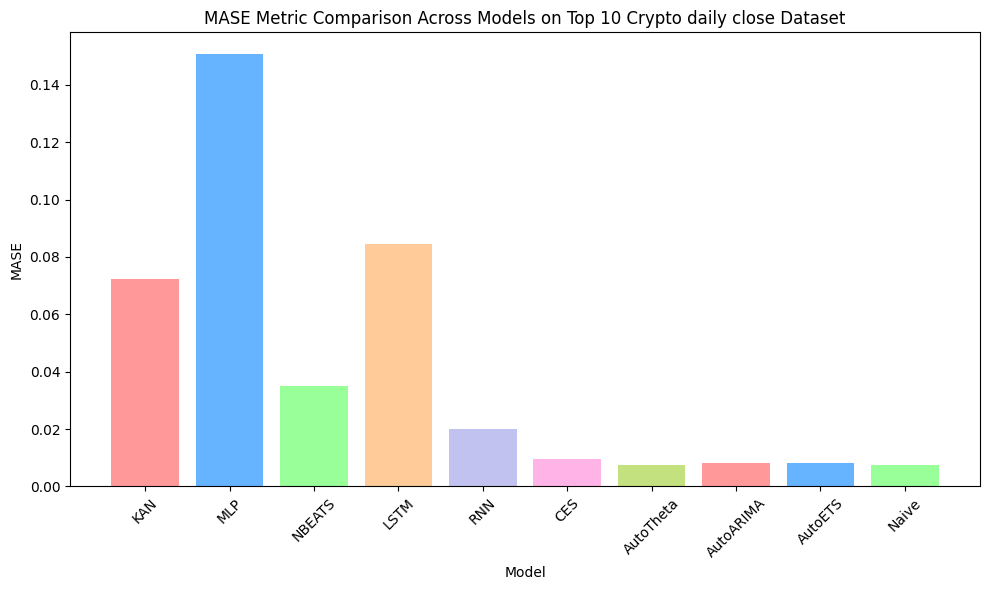

In [ ]:
# Filter for mase metric
mase_data = evaluation[evaluation["metric"] == "mse"].set_index("metric").transpose()

# Colors for each model
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c4e17f']

# Plotting the barchart for mase with different colors
plt.figure(figsize=(10, 6))
plt.bar(mase_data.index, mase_data["mse"], color=colors)
plt.title("MASE Metric Comparison Across Models on Top 10 Crypto daily close Dataset")
plt.xlabel("Model")
plt.ylabel("MASE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
stats_preds['CES']

0      0.152881
1      0.152656
2      0.152068
3      0.151772
4      0.151245
         ...   
725    0.864571
726    0.867706
727    0.870853
728    0.874012
729    0.877181
Name: CES, Length: 730, dtype: float64

Text(0.5, 1.0, 'Support Vector Regression Performance (R^2 = -33.74)')

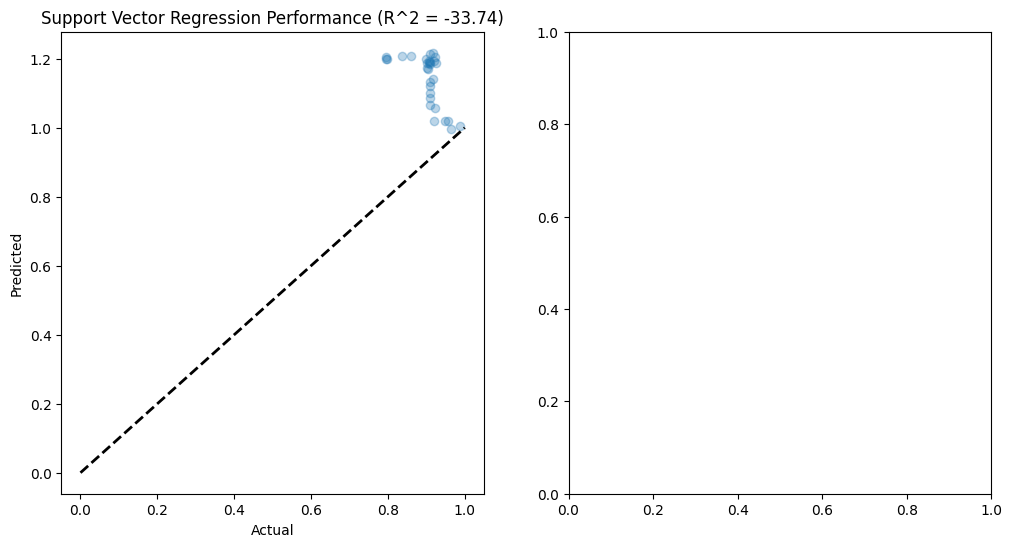

In [ ]:
import sklearn.metrics as skl
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
r2 = skl.r2_score(test_df['y'], neural_preds['KAN'])
stats_models
ax1.scatter(test_df['y'], neural_preds['KAN'], alpha=0.3)
ax1.plot([train_df['y'].min(), train_df['y'].max()], [train_df['y'].min(), train_df['y'].max()], 'k--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title(f'Support Vector Regression Performance (R^2 = {r2:.2f})')

AttributeError: 'AutoCES' object has no attribute 'mean_absolute_error'

# **KAN vs MLP**

In [ ]:
!pip install optuna

[*********************100%***********************]  1 of 1 completed


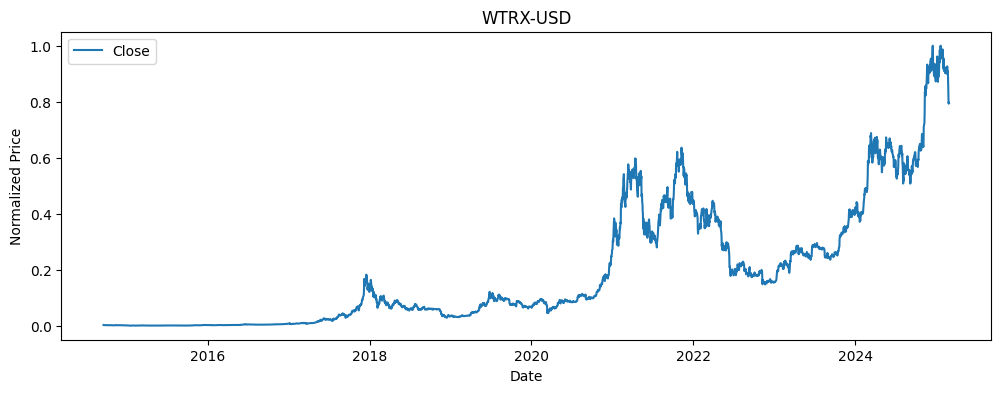

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = yf.download("BTC-USD",start="2010-03-01",end="2025-03-01")
Y_df=pd.DataFrame({'unique_id':[0 for i in range(len(data))],'ds':list(data.index),'y':list(data.iloc[:, 0])})
scaler = MinMaxScaler()
Y_df['y'] = scaler.fit_transform(Y_df['y'].values.reshape(-1, 1))

t = Y_df['ds']
data = Y_df['y']

# Plot the generated data
plt.figure(figsize=(12, 4))
plt.plot(t, data, label='Close')
plt.title('WTRX-USD')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [ ]:
# Define the window size
n_steps = 4

# Create input-output pairs
X = []
y = []
for i in range(len(data) - n_steps):
    X.append(data[i:i + n_steps])
    y.append(data[i + n_steps])

X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Split the data into training and testing sets (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_size = n_steps

In [ ]:
import optuna
learning_rate = 0.001
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Evaluate on test data
        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                epoch_test_loss += loss.item() * X_batch.size(0)
        epoch_test_loss /= len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    return train_losses, test_losses

In [ ]:



def objective_mlp(trial):
    # Define hyperparameters to tune
    hidden_size = trial.suggest_int('hidden_size', 16, 128)

    class MLP(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(MLP, self).__init__()
            # Using hidden_size as a hyperparameter
            self.layer_funcs = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.ReLU()
                ) if i % 3 == 0 else nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.Sigmoid()
                ) if i % 3 == 1 else nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.LeakyReLU()
                ) for i in range(input_size)
            ])

            self.combine_funcs = nn.Sequential(
                nn.Linear(hidden_size * input_size, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )

        def forward(self, x):
            layer_outputs = [func(x) for func in self.layer_funcs]
            concat_outputs = torch.cat(layer_outputs, dim=1)
            out = self.combine_funcs(concat_outputs)
            return out

    model = MLP(input_size, hidden_size)

    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs=50)

    return test_losses[-1]

# Create study and optimize
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(objective_mlp, n_trials=10)

print(f"Best hyperparameters for MLP: {study_mlp.best_params}")

[I 2025-03-30 10:35:20,846] A new study created in memory with name: no-name-5a68fd5d-034d-4f4f-b003-79dc876acfa5


Epoch [10/50], Train Loss: 0.0007, Test Loss: 0.0133
Epoch [20/50], Train Loss: 0.0009, Test Loss: 0.0094
Epoch [30/50], Train Loss: 0.0017, Test Loss: 0.0106
Epoch [40/50], Train Loss: 0.0007, Test Loss: 0.0077


[I 2025-03-30 10:35:40,442] Trial 0 finished with value: 0.006219055582946203 and parameters: {'hidden_size': 52}. Best is trial 0 with value: 0.006219055582946203.


Epoch [50/50], Train Loss: 0.0008, Test Loss: 0.0062
Epoch [10/50], Train Loss: 0.0006, Test Loss: 0.0018
Epoch [20/50], Train Loss: 0.0014, Test Loss: 0.0242
Epoch [30/50], Train Loss: 0.0007, Test Loss: 0.0064
Epoch [40/50], Train Loss: 0.0012, Test Loss: 0.0077


[I 2025-03-30 10:35:58,449] Trial 1 finished with value: 0.00961481641030835 and parameters: {'hidden_size': 29}. Best is trial 0 with value: 0.006219055582946203.


Epoch [50/50], Train Loss: 0.0013, Test Loss: 0.0096
Epoch [10/50], Train Loss: 0.0002, Test Loss: 0.0041
Epoch [20/50], Train Loss: 0.0004, Test Loss: 0.0117
Epoch [30/50], Train Loss: 0.0005, Test Loss: 0.0057
Epoch [40/50], Train Loss: 0.0008, Test Loss: 0.0060


[I 2025-03-30 10:36:15,690] Trial 2 finished with value: 0.004564380804186645 and parameters: {'hidden_size': 40}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0005, Test Loss: 0.0046
Epoch [10/50], Train Loss: 0.0008, Test Loss: 0.0229
Epoch [20/50], Train Loss: 0.0009, Test Loss: 0.0111
Epoch [30/50], Train Loss: 0.0010, Test Loss: 0.0101
Epoch [40/50], Train Loss: 0.0009, Test Loss: 0.0087


[I 2025-03-30 10:36:36,147] Trial 3 finished with value: 0.007816395850493273 and parameters: {'hidden_size': 120}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0009, Test Loss: 0.0078
Epoch [10/50], Train Loss: 0.0006, Test Loss: 0.0156
Epoch [20/50], Train Loss: 0.0005, Test Loss: 0.0083
Epoch [30/50], Train Loss: 0.0013, Test Loss: 0.0114
Epoch [40/50], Train Loss: 0.0010, Test Loss: 0.0098


[I 2025-03-30 10:36:54,664] Trial 4 finished with value: 0.008349158837756589 and parameters: {'hidden_size': 96}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0009, Test Loss: 0.0083
Epoch [10/50], Train Loss: 0.0005, Test Loss: 0.0141
Epoch [20/50], Train Loss: 0.0013, Test Loss: 0.0074
Epoch [30/50], Train Loss: 0.0010, Test Loss: 0.0081
Epoch [40/50], Train Loss: 0.0009, Test Loss: 0.0062


[I 2025-03-30 10:37:15,096] Trial 5 finished with value: 0.007985552356652867 and parameters: {'hidden_size': 120}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0006, Test Loss: 0.0080
Epoch [10/50], Train Loss: 0.0050, Test Loss: 0.0045
Epoch [20/50], Train Loss: 0.0009, Test Loss: 0.0150
Epoch [30/50], Train Loss: 0.0010, Test Loss: 0.0062
Epoch [40/50], Train Loss: 0.0012, Test Loss: 0.0079


[I 2025-03-30 10:37:35,872] Trial 6 finished with value: 0.005701655500017956 and parameters: {'hidden_size': 126}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0009, Test Loss: 0.0057
Epoch [10/50], Train Loss: 0.0004, Test Loss: 0.0070
Epoch [20/50], Train Loss: 0.0005, Test Loss: 0.0042
Epoch [30/50], Train Loss: 0.0007, Test Loss: 0.0139
Epoch [40/50], Train Loss: 0.0005, Test Loss: 0.0039


[I 2025-03-30 10:37:52,449] Trial 7 finished with value: 0.007104737081151178 and parameters: {'hidden_size': 24}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0010, Test Loss: 0.0071
Epoch [10/50], Train Loss: 0.0005, Test Loss: 0.0043
Epoch [20/50], Train Loss: 0.0016, Test Loss: 0.0168
Epoch [30/50], Train Loss: 0.0007, Test Loss: 0.0085
Epoch [40/50], Train Loss: 0.0003, Test Loss: 0.0111


[I 2025-03-30 10:38:09,899] Trial 8 finished with value: 0.006905238136776075 and parameters: {'hidden_size': 48}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0007, Test Loss: 0.0069
Epoch [10/50], Train Loss: 0.0261, Test Loss: 0.1718
Epoch [20/50], Train Loss: 0.0256, Test Loss: 0.1758
Epoch [30/50], Train Loss: 0.0252, Test Loss: 0.1782
Epoch [40/50], Train Loss: 0.0250, Test Loss: 0.1797


[I 2025-03-30 10:38:30,516] Trial 9 finished with value: 0.180686847117594 and parameters: {'hidden_size': 98}. Best is trial 2 with value: 0.004564380804186645.


Epoch [50/50], Train Loss: 0.0248, Test Loss: 0.1807
Best hyperparameters for MLP: {'hidden_size': 40}


NameError: name 'MLP' is not defined

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        # Using hidden_size as a hyperparameter
        self.layer_funcs = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU()
            ) if i % 3 == 0 else nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.Sigmoid()
            ) if i % 3 == 1 else nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.LeakyReLU()
            ) for i in range(input_size)
        ])

        self.combine_funcs = nn.Sequential(
            nn.Linear(hidden_size * input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        layer_outputs = [func(x) for func in self.layer_funcs]
        concat_outputs = torch.cat(layer_outputs, dim=1)
        out = self.combine_funcs(concat_outputs)
        return out

mlp_model = MLP(4, study_mlp.best_params['hidden_size'])

mlp_train_losses, mlp_test_losses = train_model(mlp_model, train_loader, test_loader, num_epochs=50)

Epoch [10/50], Train Loss: 0.0003, Test Loss: 0.0008
Epoch [20/50], Train Loss: 0.0016, Test Loss: 0.0417
Epoch [30/50], Train Loss: 0.0005, Test Loss: 0.0025
Epoch [40/50], Train Loss: 0.0012, Test Loss: 0.0087
Epoch [50/50], Train Loss: 0.0006, Test Loss: 0.0042


In [ ]:
def objective_kan(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_int('hidden_size', 0.001, 0.01)
    hidden_size = trial.suggest_int('hidden_size', 4, 64)

    class KAN(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(KAN, self).__init__()
            self.univariate_funcs = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.ReLU()
                ) if i % 3 == 0 else nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Sigmoid()
                ) if i % 3 == 1 else nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.LeakyReLU()
                ) for i in range(input_size)
            ])

            self.combine_funcs = nn.Sequential(
                nn.Linear(input_size * hidden_size, 1)
            )

        def forward(self, x):
            univariate_outputs = []
            for i in range(x.size(1)):
                xi = x[:, i].unsqueeze(1)
                univariate_output = self.univariate_funcs[i](xi)
                univariate_outputs.append(univariate_output)
            concat_outputs = torch.cat(univariate_outputs, dim=1)
            out = self.combine_funcs(concat_outputs)
            return out

    model = KAN(input_size, hidden_size)

    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs=50)

    return test_losses[-1]

# Create study and optimize
study_kan = optuna.create_study(direction='minimize')
study_kan.optimize(objective_kan, n_trials=100)

print(f"Best hyperparameters for KAN: {study_kan.best_params}")

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Evaluate on test data
        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                epoch_test_loss += loss.item() * X_batch.size(0)
        epoch_test_loss /= len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    return train_losses, test_losses

In [ ]:
class KAN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(KAN, self).__init__()
        self.univariate_funcs = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.ReLU()
            ) if i % 3 == 0 else nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Sigmoid()
            ) if i % 3 == 1 else nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.LeakyReLU()
            ) for i in range(input_size)
        ])

        self.combine_funcs = nn.Sequential(
            nn.Linear(input_size * hidden_size, 1)
        )

    def forward(self, x):
        univariate_outputs = []
        for i in range(x.size(1)):
            xi = x[:, i].unsqueeze(1)
            univariate_output = self.univariate_funcs[i](xi)
            univariate_outputs.append(univariate_output)
        concat_outputs = torch.cat(univariate_outputs, dim=1)
        out = self.combine_funcs(concat_outputs)
        return out

kan_model = KAN(input_size, 5)

kan_train_losses, kan_test_losses = train_model(kan_model, train_loader, test_loader, num_epochs=50)

Epoch [10/50], Train Loss: 0.0168, Test Loss: 0.0802
Epoch [20/50], Train Loss: 0.0013, Test Loss: 0.0160
Epoch [30/50], Train Loss: 0.0001, Test Loss: 0.0067
Epoch [40/50], Train Loss: 0.0001, Test Loss: 0.0048
Epoch [50/50], Train Loss: 0.0001, Test Loss: 0.0044


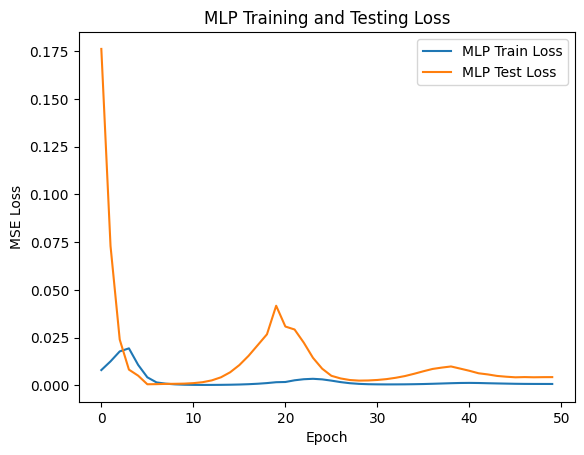

In [ ]:
plt.plot(mlp_train_losses, label='MLP Train Loss')
plt.plot(mlp_test_losses, label='MLP Test Loss')
plt.title('MLP Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

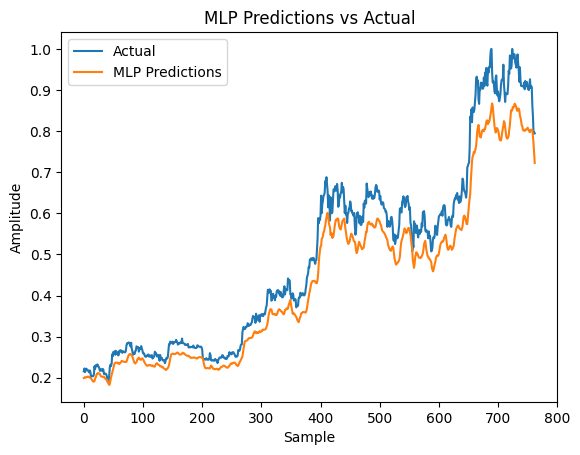

In [ ]:
def evaluate_model(model, X_data, y_data):
    model.eval()
    with torch.no_grad():
        predictions = model(X_data).squeeze().numpy()
    return predictions

# Get predictions on test data
mlp_predictions = evaluate_model(mlp_model, X_test, y_test)
plt.plot(y_test, label='Actual')
plt.plot(mlp_predictions, label='MLP Predictions')
plt.title('MLP Predictions vs Actual')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

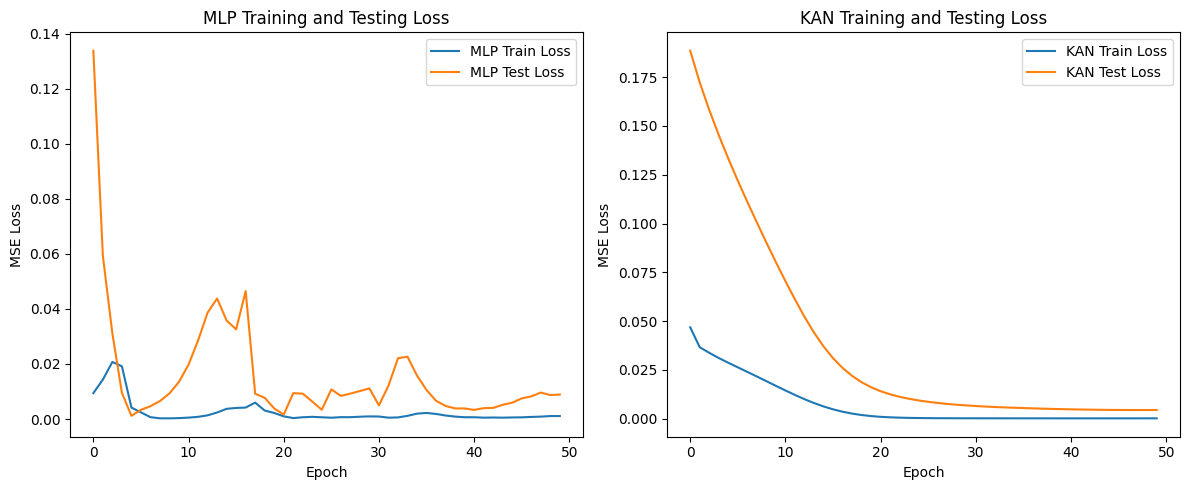

In [ ]:
# Plot training and testing losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mlp_train_losses, label='MLP Train Loss')
plt.plot(mlp_test_losses, label='MLP Test Loss')
plt.title('MLP Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(kan_train_losses, label='KAN Train Loss')
plt.plot(kan_test_losses, label='KAN Test Loss')
plt.title('KAN Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

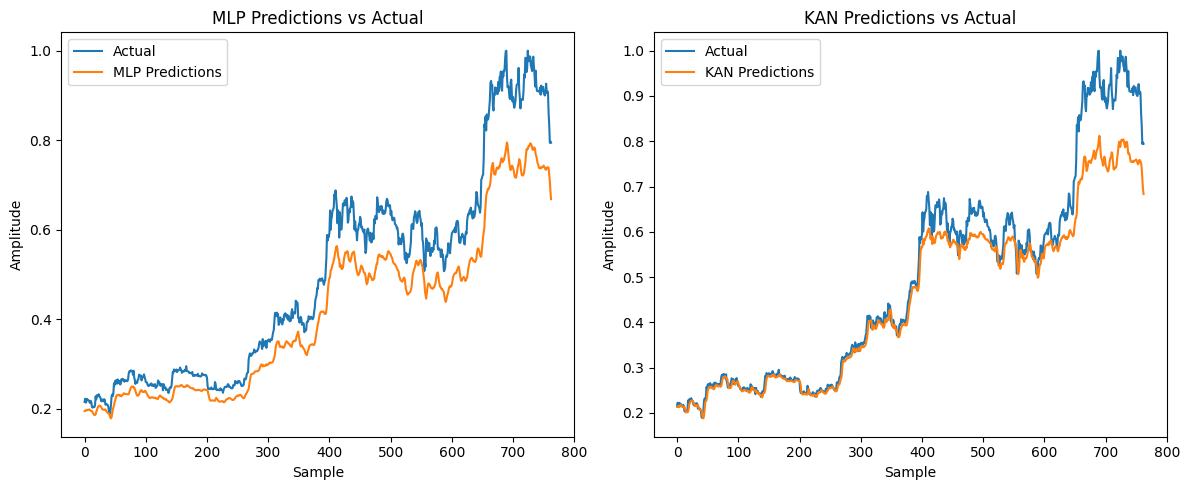

In [ ]:
def evaluate_model(model, X_data, y_data):
    model.eval()
    with torch.no_grad():
        predictions = model(X_data).squeeze().numpy()
    return predictions

# Get predictions on test data
mlp_predictions = evaluate_model(mlp_model, X_test, y_test)
kan_predictions = evaluate_model(kan_model, X_test, y_test)

#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse Transformations
#mlp_predictions = scaler.inverse_transform(mlp_predictions.reshape(-1, 1))
#kan_predictions = scaler.inverse_transform(kan_predictions.reshape(-1, 1))

# Plot the predictions vs actual values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(mlp_predictions, label='MLP Predictions')
plt.title('MLP Predictions vs Actual')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual')
plt.plot(kan_predictions, label='KAN Predictions')
plt.title('KAN Predictions vs Actual')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_error_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}")

print_error_metrics(y_test, mlp_predictions, "MLP")
print_error_metrics(y_test, kan_predictions, "KAN")

MLP - MSE: 0.0089, MAE: 0.0787
KAN - MSE: 0.0044, MAE: 0.0395


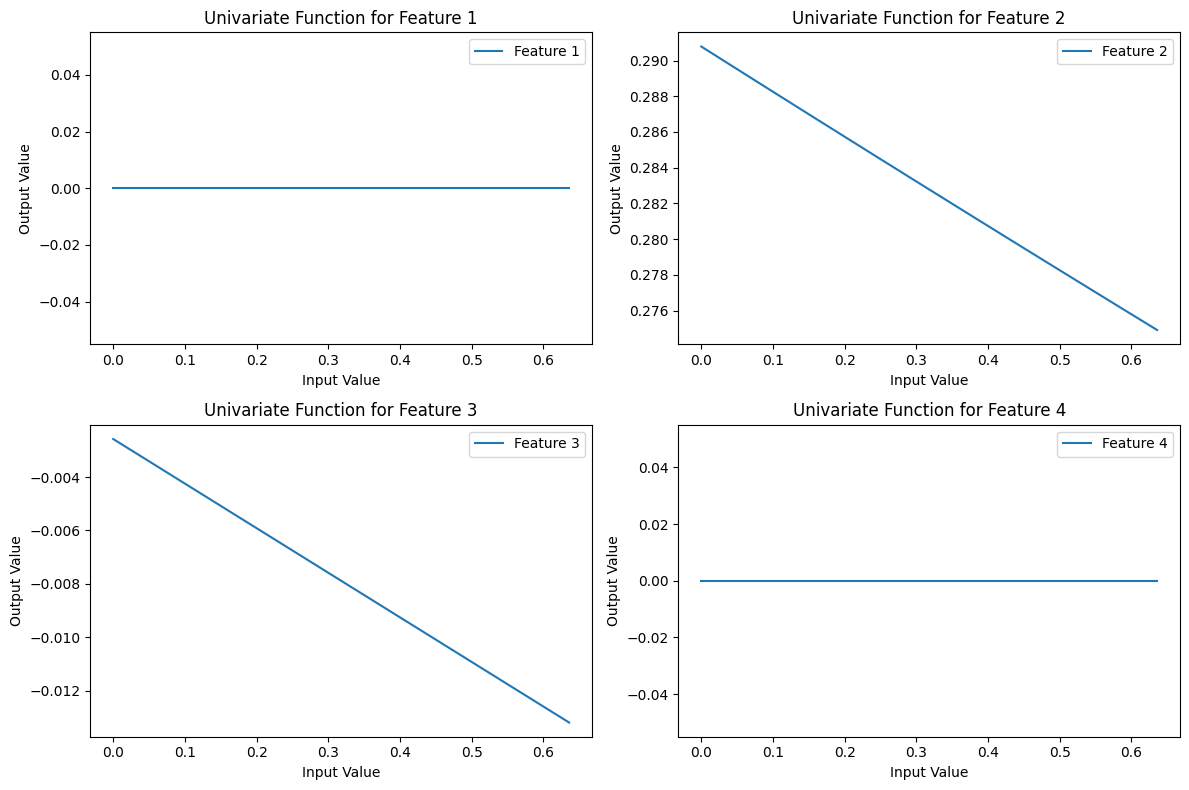

In [ ]:
def plot_univariate_functions(kan_model, X_data, feature_names=None):
    num_features = X_data.size(1)
    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(num_features)]

    plt.figure(figsize=(12, 8))

    for i in range(num_features):
        # Get the specific univariate function for the feature
        univariate_func = kan_model.univariate_funcs[i]

        # Generate a range of input values
        xi_min = X_data[:, i].min().item()
        xi_max = X_data[:, i].max().item()
        xi_range = torch.linspace(xi_min, xi_max, 100).unsqueeze(1)

        # Pass through the univariate function and take the first output
        with torch.no_grad():
            yi = univariate_func(xi_range)[:, 0].squeeze().numpy()  # Only take the first output

        # Plot the function
        plt.subplot((num_features + 1) // 2, 2, i + 1)
        plt.plot(xi_range.numpy(), yi, label=f'Feature {i+1}')
        plt.title(f'Univariate Function for {feature_names[i]}')
        plt.xlabel('Input Value')
        plt.ylabel('Output Value')
        plt.legend()  # Add a legend to label each line

    plt.tight_layout()
    plt.show()

# Plot the univariate functions
plot_univariate_functions(kan_model, X_train)

In [ ]:
def compute_feature_sensitivity(kan_model, X_sample):
    X_sample = X_sample.unsqueeze(0)  # Add batch dimension
    X_sample.requires_grad = True
    output = kan_model(X_sample)
    output.backward()
    sensitivities = X_sample.grad.squeeze().numpy()
    return sensitivities

# Example usage
sample_index = 0  # Index of the sample you want to analyze
sensitivities = compute_feature_sensitivity(kan_model, X_test[sample_index])
print("Feature Sensitivities:", sensitivities)

Feature Sensitivities: [0.         0.12871365 0.5557927  0.29004186]


In [ ]:
def plot_univariate_functions(kan_model, X_data, feature_names=None):
    num_features = X_data.size(1)
    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(num_features)]

    plt.figure(figsize=(12, 8))

    for i in range(num_features):
        # Set up the subplot before plotting
        plt.subplot((num_features + 1) // 2, 2, i + 1)

        # Get the specific univariate function for the feature
        univariate_func = kan_model.univariate_funcs[i]

        # Generate a range of input values
        xi_min = X_data[:, i].min().item()
        xi_max = X_data[:, i].max().item()
        xi_range = torch.linspace(xi_min, xi_max, 100).unsqueeze(1)

        # Pass through the univariate function
        with torch.no_grad():
            yi_all = univariate_func(xi_range)
            for j in range(yi_all.size(1)):  # Plot each output line separately
                yi = yi_all[:, j].squeeze().numpy()
                plt.plot(xi_range.numpy(), yi, label=f'Intermediate Output {j+1}')

        # Add titles and labels
        plt.title(f'Univariate Function for {feature_names[i]}')
        plt.xlabel('Input Value')
        plt.ylabel('Output Value')

        # Add a legend only if labels are present
        if yi_all.size(1) > 0:
            plt.legend()

    plt.tight_layout()
    plt.show()

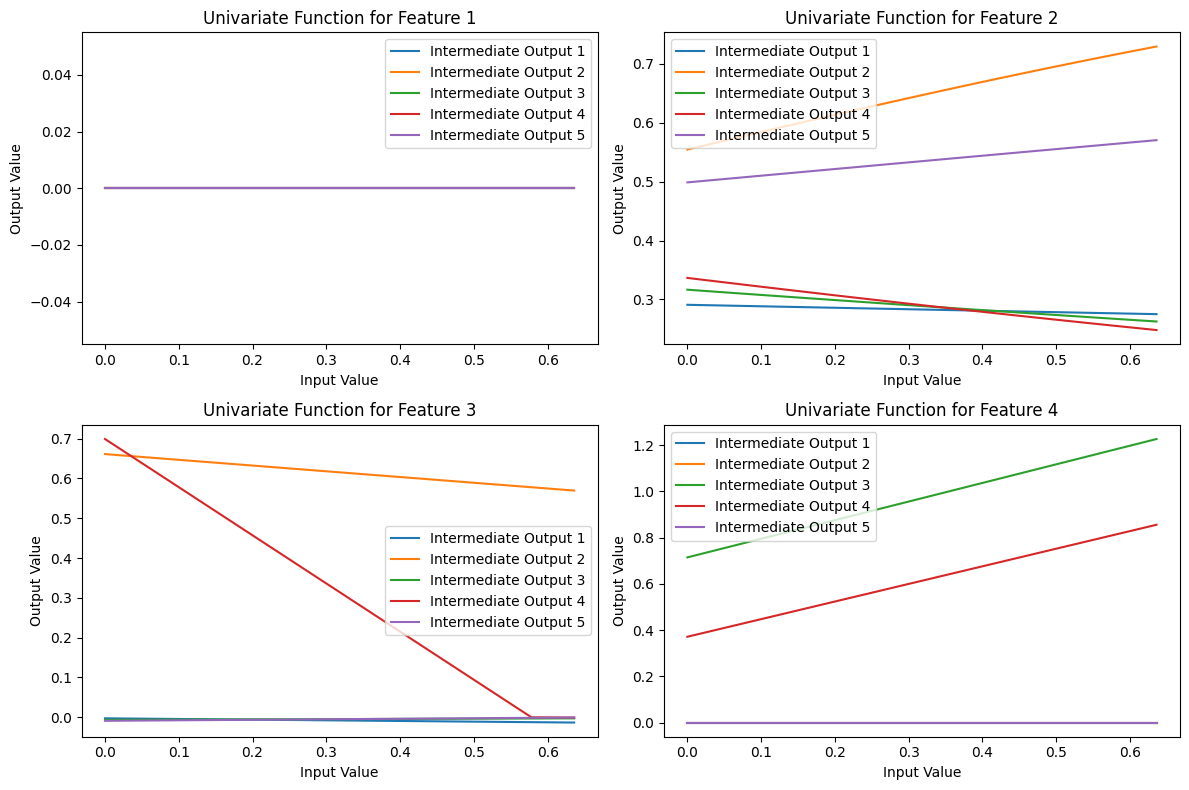

In [ ]:
plot_univariate_functions(kan_model, X_train)

# KAN as ENSEMBLE LEARNER

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dense, Flatten, Dropout, LSTM
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge

X_train_LSTM = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_LSTM = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_LSTM = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

def bRFR(best_params):
  rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
  return rf_best

def bLR(best_params):
  if best_params["model_type"] == "ridge":
    model_best = Ridge(alpha=best_params["alpha"], random_state=42)
  else:
    model_best = Lasso(alpha=best_params["alpha"], random_state=42)
  return model_best

def bGBR(best_params):
  best_gb = GradientBoostingRegressor(
    **best_params,
    random_state=42
  )
  return best_gb

def bGRU(best_params):
  best_model = Sequential()
  best_model.add(GRU(units=best_params["n_units"], return_sequences=True, input_shape=(3, 1)))
  best_model.add(GRU(units=best_params["n_units"]))
  best_model.add(Dense(1))
  best_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss='mean_squared_error')
  return best_model

def bLSTM(best_params):
  best_model = Sequential()
  best_model.add(LSTM(units=best_params['n_units'], return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
  best_model.add(Dropout(best_params['dropout_rate']))
  best_model.add(LSTM(units=best_params['n_units']))
  best_model.add(Dropout(best_params['dropout_rate']))
  best_model.add(Dense(1))
  best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')
  return best_model

def bMLP(best_params):
  best_model = Sequential()
  best_model.add(Flatten(input_shape=(X_train.shape[1],)))
  for _ in range(best_params["n_layers"]):
      best_model.add(Dense(units=best_params["n_units"], activation='relu'))
  best_model.add(Dense(1))
  best_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss='mean_squared_error')
  return best_model


best_params={'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}
rfr_model = bRFR(best_params)
rfr_model.fit(X_train, y_train)
val_preds_rfr = rfr_model.predict(X_val)
test_preds_rfr = rfr_model.predict(X_test)
r2 = r2_score(y_test, test_preds_rfr)
print(r2)

best_params={'model_type': 'ridge', 'alpha': 0.0013957618281066919}
lr_model = bLR(best_params)
lr_model.fit(X_train, y_train)
val_preds_lr = lr_model.predict(X_val)
test_preds_lr = lr_model.predict(X_test)
r2 = r2_score(y_test, test_preds_lr)
print(r2)


best_params={'n_estimators': 409, 'learning_rate': 0.2687756080212663, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.6983834983261011, 'max_features': 'sqrt'}
gbr_model = bGBR(best_params)
gbr_model.fit(X_train, y_train)
val_preds_gbr = gbr_model.predict(X_val)
test_preds_gbr = gbr_model.predict(X_test)
r2 = r2_score(y_test, test_preds_gbr)
print(r2)

best_params={'n_units': 90, 'learning_rate': 0.00035392099682904875, 'dropout_rate': 0.2118285720165366, 'n_batch': 83}
lstm_model = bLSTM(best_params)
lstm_model.fit(X_train_LSTM, y_train, epochs=50, batch_size=best_params["n_batch"], validation_data=(X_val_LSTM, y_val))
val_preds_lstm = lstm_model.predict(X_val_LSTM).flatten()
test_preds_lstm = lstm_model.predict(X_test_LSTM).flatten()
r2 = r2_score(y_test, test_preds_lstm)
print(r2)


best_params={'n_units': 122, 'n_epochs': 60, 'n_batch': 64, 'learning_rate': 1.1526170513193388e-05}
gru_model = bGRU(best_params)
gru_model.fit(X_train_LSTM, y_train, epochs=best_params["n_epochs"], batch_size=best_params["n_batch"], validation_data=(X_val_LSTM, y_val))
val_preds_gru = gru_model.predict(X_val_LSTM).flatten()
test_preds_gru = gru_model.predict(X_test_LSTM).flatten()
r2 = r2_score(y_test, test_preds_gru)
print(r2)

best_params={'n_layers': 3, 'n_units': 122, 'n_epochs': 42, 'n_batch': 64, 'learning_rate': 0.0002264186806791356}
mlp_model = bMLP(best_params)
mlp_model.fit(X_train, y_train, epochs=best_params["n_epochs"], batch_size=best_params["n_batch"], validation_data=(X_val, y_val))
val_preds_mlp = mlp_model.predict(X_val).flatten()
test_preds_mlp = mlp_model.predict(X_test).flatten()
r2 = r2_score(y_test, test_preds_mlp)
print(r2)

Enter the number:12
Enter the size:9
12  *  1  =  12
12  *  2  =  24
12  *  3  =  36
12  *  4  =  48
12  *  5  =  60
12  *  6  =  72
12  *  7  =  84
12  *  8  =  96
12  *  9  =  108


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_meta_train = np.stack([val_preds_lstm, val_preds_gru, val_preds_mlp], axis=1)
X_meta_test = np.stack([val_preds_lstm, val_preds_gru, val_preds_mlp], axis=1)

# === STEP 1: Prepare meta-inputs (already done)
X_meta_train_tensor = torch.tensor(X_meta_train, dtype=torch.float32)
y_meta_train_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_meta_test_tensor = torch.tensor(X_meta_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# === STEP 2: Define KAN model
class KAN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(KAN, self).__init__()
        self.univariate_funcs = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.ReLU()
            ) if i % 3 == 0 else nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Sigmoid()
            ) if i % 3 == 1 else nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.LeakyReLU()
            ) for i in range(input_size)
        ])

        self.combine_funcs = nn.Sequential(
            nn.Linear(input_size * hidden_size, 1)
        )

    def forward(self, x):
        univariate_outputs = [self.univariate_funcs[i](x[:, i].unsqueeze(1)) for i in range(x.size(1))]
        concat_outputs = torch.cat(univariate_outputs, dim=1)
        return self.combine_funcs(concat_outputs)

# === STEP 3: Define Optuna Objective Function
def objective(trial):
    input_size = X_train.shape[1]
    hidden_size = trial.suggest_int('hidden_size', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    num_epochs = 20

    # Initialize model
    model = KAN(input_size, hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Train model
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        # Convert X_train to a NumPy array before creating a tensor
        outputs = model(torch.tensor(X_train.values, dtype=torch.float32))  # Changed line
        loss = criterion(outputs, torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)) # Changed line
        loss.backward()
        optimizer.step()

    # Evaluate model
    model.eval()
    with torch.no_grad():
        # Convert X_val to a NumPy array before creating a tensor
        y_pred = model(torch.tensor(X_val.values, dtype=torch.float32)).numpy()  # Changed line

    # Compute RMSE
    #r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse
count2 = 0
prev_r2 = 0
r2 = 0
while count2 < 10:
  # === STEP 4: Run Optuna
  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=100)

  print("Best Hyperparameters:", study.best_params)

  # === STEP 5: Retrain Final Meta-Model with Best Params
  best_hidden_size = study.best_params['hidden_size']
  best_lr = study.best_params['learning_rate']

  count1 = 0
  while count1 < 100:
    final_model = KAN(input_size=3, hidden_size=best_hidden_size)
    optimizer = optim.Adam(final_model.parameters(), lr=best_lr)
    criterion = nn.MSELoss()

    for epoch in range(50):
        final_model.train()
        optimizer.zero_grad()
        outputs = final_model(X_meta_train_tensor)
        loss = criterion(outputs, y_meta_train_tensor)
        loss.backward()
        optimizer.step()

    # === STEP 6: Final Evaluation
    final_model.eval()
    with torch.no_grad():
        y_meta_pred = final_model(X_meta_test_tensor).numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_test, y_meta_pred))
    mse = mean_squared_error(y_test, y_meta_pred)
    mae = mean_absolute_error(y_test, y_meta_pred)
    r2 = r2_score(y_test, y_meta_pred)

    performance_metrics_stacked = {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    if r2 > prev_r2:
      bestt_params = study.best_params
      bestt_model = final_model
      with torch.no_grad():
        y_meta_best_pred = bestt_model(X_meta_test_tensor).numpy().flatten()
      prev_r2 = r2
      prev_rmse = rmse
      prev_mse = mse
      prev_mae = mae

    print("Performance Metrics (Stacked, Tuned):", performance_metrics_stacked)
    count1 += 1
  count2 += 1

NameError: name 'lala' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color gradient based on error magnitude
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 6))  # Set figure size
sc = plt.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.6, edgecolors='k', s=60)

# Plot the ideal diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2, label="Ideal Fit")

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error")

# Labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs. Predicted Values', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [ ]:
# Ensure you use the same scaler that was used for fitting
y_test_inv = Scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_pred_lstm_inv = Scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Plot Actual vs Predicted Prices for LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_pred_lstm_inv, label="Predicted Prices", color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))  # Set figure size

# Scatter plot with color gradient
sc = plt.scatter(y_pred, residuals, c=np.abs(residuals), cmap='coolwarm', alpha=0.6, edgecolors='k', s=60)

# Horizontal reference line at zero residual
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual")

# Color bar to indicate residual magnitude
cbar = plt.colorbar(sc)
cbar.set_label("Absolute Residuals")

# Labels and title
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch

# Convert tensors to NumPy arrays
X_np = X_meta_train_tensor.numpy()
y_np = y_meta_train_tensor.numpy()

train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for frac in train_sizes:
    size = int(frac * len(X_np))
    X_frac = torch.tensor(X_np[:size], dtype=torch.float32)
    y_frac = torch.tensor(y_np[:size], dtype=torch.float32)

    model = bestt_model  # Your best model instance
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        output = model(X_frac).squeeze()
        loss = criterion(output, y_frac)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_pred = model(X_frac).squeeze().numpy()
        val_pred = model(X_meta_test_tensor).squeeze().numpy()

    train_rmse = mean_squared_error(y_frac.numpy(), train_pred)
    val_rmse = mean_squared_error(y_pred, val_pred)

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

train_errors.sort(reverse=True)
val_errors.sort(reverse=True)

# Plot with enhanced visuals
plt.figure(figsize=(10, 6))

# Gradient-like effect using scatter points
sc1 = plt.scatter(train_sizes * len(X_np), train_errors, c=train_errors, cmap='coolwarm', label='Training RMSE', s=60, edgecolors='k', alpha=0.8)
sc2 = plt.scatter(train_sizes * len(X_np), val_errors, c=val_errors, cmap='coolwarm', label='Validation RMSE', s=60, edgecolors='k', alpha=0.8)

# Lines connecting points
plt.plot(train_sizes * len(X_np), train_errors, color='blue', linewidth=3, alpha=1)
plt.plot(train_sizes * len(X_np), val_errors, color='red', linewidth=3, alpha=1)

# Colorbar to show error scale
cbar = plt.colorbar(sc2)
cbar.set_label("RMSE Magnitude")

# Axes, title, and grid styling
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Learning Curve for KAN Meta-Model', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size
plt.figure(figsize=(8, 6))

# Plot histogram with KDE (density=True makes it comparable)
sns.histplot(residuals, bins=25, kde=True, color='blue', alpha=0.6, edgecolor='black')

# Add vertical line at zero residual
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

# Labels and title
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Residuals', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()